In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import os
import h5py as hdf
import scipy as scp

plt.rcParams['figure.facecolor'] = 'white'

In [2]:
positions=pd.read_excel('Y:\\Istra Repositories\\ch-gr_exports\\Querzug_overview.xlsx')
positions.name=positions.name+'_clipped_cut_lined'
positions=positions.iloc[:,1:].set_index('name')
display(positions)

,ok,crack,pos,left_12-5,step_start,step_stop
name,,,,,,
MC_A_6xi_clipped_cut_lined,1.0,135.0,143.0,123.0,110.0,230.0
MC_A_6xiii_clipped_cut_lined,1.0,115.0,119.0,99.0,45.0,187.5
MC_A_6yi_clipped_cut_lined,2.0,114.0,117.0,97.0,NaN,NaN
MC_A_6yii_clipped_cut_lined,2.0,47.0,50.0,30.0,NaN,NaN
MC_A_6yiii_clipped_cut_lined,2.0,100.0,95.0,75.0,NaN,NaN
...,...,...,...,...,...,...
QL_A_8yv_clipped_cut_lined,1.0,125.0,135.0,115.0,45.0,325.0
QL_A_8yvi_clipped_cut_lined,1.0,138.0,133.0,113.0,35.0,315.0
QL_B_8yiv_clipped_cut_lined,1.0,145.0,135.0,115.0,100.0,390.0


In [3]:
import os
import re

def gather_files_regex(dir: str,regex)->list:
    '''
    Gathers all files below a directory that match the provided regular expression
    Traverses into sub-directories

    dir -- the directory

    regex -- A regular expression to match filenames
    '''
    subdir=dir
    p = re.compile(regex)
    data=[]
    for dir, _, files in os.walk(subdir):
        for name in files:
            if p.match(name):
                b=(str(os.path.join(dir, name)))
                data.append(b)
    return data

files=gather_files_regex('Y:\\Istra Repositories\\ch-gr_exports',r'\w+ned.pickle\Z')
display(files)

['Y:\\Istra Repositories\\ch-gr_exports\\MC_A_6xiii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_6xi_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_A_8xiii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_B_6xiii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_B_6xii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_B_6xi_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_B_8xiii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_B_8xi_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_B_8yi_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_GW_6xiii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_GW_6xi_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_GW_6yiii_clipped_cut_lined.pickle',
 'Y:\\Istra Repositories\\ch-gr_exports\\MC_GW_6yii_clipped_

In [4]:
sample='MC_A_8xiii_clipped_cut'
samplelocation='Y:\\Istra Repositories\\ch-gr_exports\\'+sample+'.pickle'
lookup=pd.read_pickle(samplelocation,compression='zip')

In [5]:
over_df_index=[x.split('\\')[-1].split('.')[0] for x in files]
tests_df=pd.DataFrame(index=over_df_index)
tests_df['paths']=files
tests_df=tests_df.join(positions,how='left')
tests_df['index']=tests_df.index
tests_df['material']=tests_df['index'].apply(lambda x: x.split('_')[0])
tests_df['senergie/GW']=tests_df['index'].apply(lambda x: x.split('_')[1])
tests_df['plate_thickness']=tests_df['index'].apply(lambda x: x.split('_')[2][0])
tests_df['testspeed']=tests_df['index'].apply(lambda x: x.split('_')[2][1])
tests_df['running_number']=tests_df['index'].apply(lambda x: x.split('_')[2][2:])
tests_df['data']=[pd.read_pickle(x, compression='zip') for x in tests_df['paths']]
display(tests_df.head(5))
#plt.plot(tests_df.crack)

,paths,ok,crack,pos,left_12-5,step_start,step_stop,index,material,senergie/GW,plate_thickness,testspeed,running_number,data
MC_A_6xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii...,1.0,115.0,119.0,99.0,45.0,187.5,MC_A_6xiii_clipped_cut_lined,MC,A,6,x,iii,group ...
MC_A_6xi_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_6xi_c...,1.0,135.0,143.0,123.0,110.0,230.0,MC_A_6xi_clipped_cut_lined,MC,A,6,x,i,group ...
MC_A_8xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_8xiii...,1.0,170.0,117.5,97.5,32.5,355.0,MC_A_8xiii_clipped_cut_lined,MC,A,8,x,iii,group ...
MC_B_6xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_B_6xiii...,1.0,90.0,90.0,70.0,37.5,172.5,MC_B_6xiii_clipped_cut_lined,MC,B,6,x,iii,group ...
MC_B_6xii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_B_6xii_...,1.0,122.0,121.0,101.0,27.5,160.0,MC_B_6xii_clipped_cut_lined,MC,B,6,x,ii,group ...


In [6]:
#display(test.data)

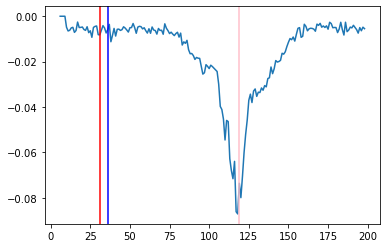

In [7]:
test=tests_df.data[0]
sample=tests_df['index'][0]
def array_get_mask(array:np.ndarray)->pd.DataFrame:
    df=pd.DataFrame(array)
    after=df.copy()
    after[after==0.]=np.nan
    after=np.divide(after,after)
    return(after)
#mask=array_get_mask(test.iloc[10,:][('strains','strain_p1')])
#plt.matshow(mask)
def df_apply_mask(arr:np.ndarray,mask:np.ndarray)-> pd.DataFrame:
    after=np.multiply(arr,mask)
    after=pd.DataFrame(after)
    after.dropna(how='all',axis=0,inplace=True)
    after.dropna(how='all',axis=1,inplace=True)
    return(after)
#plt.matshow(df_apply_mask(array_get_mask(test.iloc[10,:][('strains','strain_p1')]),mask))
def df_strip_nans(df):
    after=df.copy()
    after.dropna(how='all',axis=0,inplace=True)
    after.dropna(how='all',axis=1,inplace=True)
    return(after)
def df_get_idx_from_mm(sample:str,data:pd.DataFrame,sdix,cdix,left:int,right:int):
    mask=array_get_mask(data.iloc[10,:][('strains','strain_p1')])
    horizontal_measured_mm=data.iloc[10,:][('coordinates','coordinate_y')]
    measurement_dict=horizontal_measured_mm.to_dict()
    measurement_lookup_df=pd.DataFrame(data=measurement_dict.values(), index=measurement_dict.keys(),columns=['mm'])
    #display(measurement_lookup_df)
    crack_idx=int(cdix)
    seam_idx=int(sdix)

    seam_pos_y_mm=measurement_lookup_df.loc[seam_idx,'mm']
    left_pos_y_mm=seam_pos_y_mm-left
    right_pos_y_mm=seam_pos_y_mm-right

    left_pos_y_idx=measurement_lookup_df.iloc[(measurement_lookup_df['mm']-left_pos_y_mm).abs().argsort()[:1]].index.tolist()[0]
    right_pos_y_idx=measurement_lookup_df.iloc[(measurement_lookup_df['mm']-right_pos_y_mm).abs().argsort()[:1]].index.tolist()[0]

    """fig,ax=plt.subplots(figsize=(20,5))
    ax.matshow(df_apply_mask(data.iloc[150,:][('strains','strain_p1')],mask))
    ax.axvline(left_pos_y_idx,c='red')
    ax.axvline(right_pos_y_idx,c='yellow')
    plt.show()"""
    return(seam_idx,left_pos_y_idx,right_pos_y_idx)
def df_extract_roi_on_idx(roi_base,left,right):
    roi_base=pd.DataFrame(roi_base).copy()

    roi_base.loc[:,:left]=np.nan
    roi_base.loc[:,right:]=np.nan
    return(roi_base)
#df_get_idx_from_mm(sample,lookup,positions,-20,-18)
borders=df_get_idx_from_mm(sample,test,119.0,115.0,-35,-33)
fig,ax=plt.subplots()
ax.plot(tests_df.data[0].iloc[-10,6])#.loc[borders[1]:borders[2]])
ax.axvline(borders[1],color='red')
ax.axvline(borders[2],color='blue')
ax.axvline(borders[0],color='pink')
plt.show()
#plt.matshow(df_strip_nans(df_extract_roi_on_idx(df_apply_mask(array_get_mask(test.iloc[130,:][('strains','strain_p1')]),mask),borders[1],borders[2])))

In [8]:
display(test.iloc[0,3])



6     -23.113460
7     -23.174919
8     -23.230551
9     -23.275849
10    -23.328638
         ...    
194   -15.198407
195   -15.143376
196   -15.103652
197   -15.046472
198   -15.002882
Length: 193, dtype: float64

,paths,ok,crack,pos,left_12-5,step_start,step_stop,index,material,senergie/GW,...,15_17 _idxs,17_19 _idxs,19_21 _idxs,21_23 _idxs,23_25 _idxs,25_27 _idxs,27_29 _idxs,29_31 _idxs,31_33 _idxs,33_35 _idxs
MC_A_6xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii...,1.0,115.0,119.0,99.0,45.0,187.5,MC_A_6xiii_clipped_cut_lined,MC,A,...,"(119, 157, 162)","(119, 162, 167)","(119, 167, 172)","(119, 172, 177)","(119, 177, 182)","(119, 182, 187)","(119, 187, 192)","(119, 192, 197)","(119, 197, 198)","(119, 198, 198)"
MC_A_6xi_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_6xi_c...,1.0,135.0,143.0,123.0,110.0,230.0,MC_A_6xi_clipped_cut_lined,MC,A,...,"(143, 180, 185)","(143, 185, 190)","(143, 190, 195)","(143, 195, 200)","(143, 200, 200)","(143, 200, 200)","(143, 200, 200)","(143, 200, 200)","(143, 200, 200)","(143, 200, 200)"
MC_A_8xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_8xiii...,1.0,170.0,117.5,97.5,32.5,355.0,MC_A_8xiii_clipped_cut_lined,MC,A,...,"(117, 154, 159)","(117, 159, 163)","(117, 163, 168)","(117, 168, 173)","(117, 173, 178)","(117, 178, 183)","(117, 183, 188)","(117, 188, 193)","(117, 193, 198)","(117, 198, 201)"
MC_B_6xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_B_6xiii...,1.0,90.0,90.0,70.0,37.5,172.5,MC_B_6xiii_clipped_cut_lined,MC,B,...,"(90, 126, 131)","(90, 131, 136)","(90, 136, 141)","(90, 141, 146)","(90, 146, 151)","(90, 151, 156)","(90, 156, 161)","(90, 161, 165)","(90, 165, 170)","(90, 170, 175)"
MC_B_6xii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_B_6xii_...,1.0,122.0,121.0,101.0,27.5,160.0,MC_B_6xii_clipped_cut_lined,MC,B,...,"(121, 159, 164)","(121, 164, 169)","(121, 169, 174)","(121, 174, 179)","(121, 179, 184)","(121, 184, 189)","(121, 189, 194)","(121, 194, 199)","(121, 199, 201)","(121, 201, 201)"


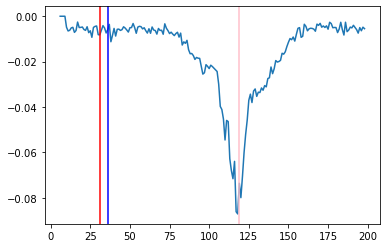

In [9]:
def idx_runner(tests_df):
    tests_df['-35_-33_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-35,-33))
    tests_df['-33_-31_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-33,-31))
    tests_df['-31_-29_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-31,-29))
    tests_df['-29_-27_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-29,-27))
    tests_df['-27_-25_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-27,-25))
    tests_df['-25_-23_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-25,-23))
    tests_df['-23_-21_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-23,-21))
    tests_df['-21_-19_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-21,-19))
    tests_df['-19_-17_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-19,-17))
    tests_df['-17_-15_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-17,-15))
    tests_df['-15_-13_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-15,-13))
    tests_df['-13_-11_idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-13,-11))
    tests_df['-11_-9 _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-11,-9))
    tests_df['-9_-7  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-9,-7))
    tests_df['-7_-5  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-7,-5))
    tests_df['-5_-3  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-5,-3))
    tests_df['-3_-1  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-3,-1))
    tests_df['-1_1   _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],-1,1))
    tests_df['1_3    _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],1,3))
    tests_df['3_5    _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],3,5))
    tests_df['5_7    _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],5,7))
    tests_df['7_9    _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],7,9))
    tests_df['9_11   _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],9,11))
    tests_df['11_13  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],11,13))
    tests_df['13_15  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],13,15))
    tests_df['15_17  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],15,17))
    tests_df['17_19  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],17,19))
    tests_df['19_21  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],19,21))
    tests_df['21_23  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],21,23))
    tests_df['23_25  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],23,25))
    tests_df['25_27  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],25,27))
    tests_df['27_29  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],27,29))
    tests_df['29_31  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],29,31))
    tests_df['31_33  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],31,33))
    tests_df['33_35  _idxs']  =  tests_df['index'].apply(lambda x:df_get_idx_from_mm(x,tests_df.loc[x,'data'],tests_df.loc[x,'pos'],tests_df.loc[x,'crack'],33,35))
    return (tests_df)
tests_df=idx_runner(tests_df)
display(tests_df.head())

fig,ax=plt.subplots()
ax.plot(tests_df.data[0].iloc[-10,6])
ax.axvline(tests_df['-35_-33_idxs'][0][1],color='red')
ax.axvline(tests_df['-35_-33_idxs'][0][2],color='blue')
ax.axvline(tests_df['-35_-33_idxs'][0][0],color='pink')
plt.show()
test=tests_df

Index(['paths', 'ok', 'crack', 'pos', 'left_12-5', 'step_start', 'step_stop',
       'index', 'material', 'senergie/GW', 'plate_thickness', 'testspeed',
       'running_number', 'data', '-35_-33_idxs', '-33_-31_idxs',
       '-31_-29_idxs', '-29_-27_idxs', '-27_-25_idxs', '-25_-23_idxs',
       '-23_-21_idxs', '-21_-19_idxs', '-19_-17_idxs', '-17_-15_idxs',
       '-15_-13_idxs', '-13_-11_idxs', '-11_-9 _idxs', '-9_-7  _idxs',
       '-7_-5  _idxs', '-5_-3  _idxs', '-3_-1  _idxs', '-1_1   _idxs',
       '1_3    _idxs', '3_5    _idxs', '5_7    _idxs', '7_9    _idxs',
       '9_11   _idxs', '11_13  _idxs', '13_15  _idxs', '15_17  _idxs',
       '17_19  _idxs', '19_21  _idxs', '21_23  _idxs', '23_25  _idxs',
       '25_27  _idxs', '27_29  _idxs', '29_31  _idxs', '31_33  _idxs',
       '33_35  _idxs'],
      dtype='object')

(142, 10)

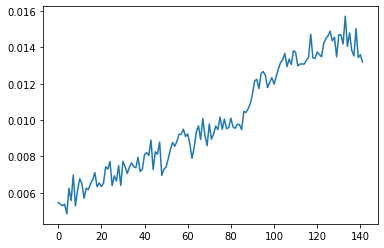

In [10]:

def df_loc_strain(df,left,right):
    strain_p1=[]
    for i in df.index:
        strain_p1.append(df.loc[i,(      'strains',          'strain_p1')].loc[left:right].mean())
    #display(strain_p1)
    #plt.plot(strain_p1)
    return(strain_p1)

display(tests_df.columns)
plt.plot(df_loc_strain(tests_df.data[0],tests_df['15_17  _idxs'][0][1],tests_df['15_17  _idxs'][0][2]))
display(tests_df.data[0].shape)

Index(['paths', 'ok', 'crack', 'pos', 'left_12-5', 'step_start', 'step_stop',
       'index', 'material', 'senergie/GW', 'plate_thickness', 'testspeed',
       'running_number', 'data', '-35_-33_idxs', '-33_-31_idxs',
       '-31_-29_idxs', '-29_-27_idxs', '-27_-25_idxs', '-25_-23_idxs',
       '-23_-21_idxs', '-21_-19_idxs', '-19_-17_idxs', '-17_-15_idxs',
       '-15_-13_idxs', '-13_-11_idxs', '-11_-9 _idxs', '-9_-7  _idxs',
       '-7_-5  _idxs', '-5_-3  _idxs', '-3_-1  _idxs', '-1_1   _idxs',
       '1_3    _idxs', '3_5    _idxs', '5_7    _idxs', '7_9    _idxs',
       '9_11   _idxs', '11_13  _idxs', '13_15  _idxs', '15_17  _idxs',
       '17_19  _idxs', '19_21  _idxs', '21_23  _idxs', '23_25  _idxs',
       '25_27  _idxs', '27_29  _idxs', '29_31  _idxs', '31_33  _idxs',
       '33_35  _idxs', '-35_-33_strain_p1', '-33_-31_strain_p1',
       '-31_-29_strain_p1', '-29_-27_strain_p1', '-27_-25_strain_p1',
       '-25_-23_strain_p1', '-23_-21_strain_p1', '-21_-19_strain_p1',
       '-

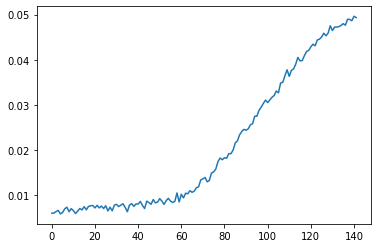

In [11]:
tests_df['-35_-33_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-35_-33_idxs'][1],tests_df.loc[i,'-35_-33_idxs'][2]) for i in tests_df.index]
tests_df['-33_-31_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-33_-31_idxs'][1],tests_df.loc[i,'-33_-31_idxs'][2]) for i in tests_df.index]
tests_df['-31_-29_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-31_-29_idxs'][1],tests_df.loc[i,'-31_-29_idxs'][2]) for i in tests_df.index]
tests_df['-29_-27_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-29_-27_idxs'][1],tests_df.loc[i,'-29_-27_idxs'][2]) for i in tests_df.index]
tests_df['-27_-25_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-27_-25_idxs'][1],tests_df.loc[i,'-27_-25_idxs'][2]) for i in tests_df.index]
tests_df['-25_-23_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-25_-23_idxs'][1],tests_df.loc[i,'-25_-23_idxs'][2]) for i in tests_df.index]
tests_df['-23_-21_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-23_-21_idxs'][1],tests_df.loc[i,'-23_-21_idxs'][2]) for i in tests_df.index]
tests_df['-21_-19_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-21_-19_idxs'][1],tests_df.loc[i,'-21_-19_idxs'][2]) for i in tests_df.index]
tests_df['-19_-17_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-19_-17_idxs'][1],tests_df.loc[i,'-19_-17_idxs'][2]) for i in tests_df.index]
tests_df['-17_-15_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-17_-15_idxs'][1],tests_df.loc[i,'-17_-15_idxs'][2]) for i in tests_df.index]
tests_df['-15_-13_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-15_-13_idxs'][1],tests_df.loc[i,'-15_-13_idxs'][2]) for i in tests_df.index]
tests_df['-13_-11_strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-13_-11_idxs'][1],tests_df.loc[i,'-13_-11_idxs'][2]) for i in tests_df.index]
tests_df['-11_-9 _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-11_-9 _idxs'][1],tests_df.loc[i,'-11_-9 _idxs'][2]) for i in tests_df.index]
tests_df['-9_-7  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-9_-7  _idxs'][1],tests_df.loc[i,'-9_-7  _idxs'][2]) for i in tests_df.index]
tests_df['-7_-5  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-7_-5  _idxs'][1],tests_df.loc[i,'-7_-5  _idxs'][2]) for i in tests_df.index]
tests_df['-5_-3  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-5_-3  _idxs'][1],tests_df.loc[i,'-5_-3  _idxs'][2]) for i in tests_df.index]
tests_df['-3_-1  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-3_-1  _idxs'][1],tests_df.loc[i,'-3_-1  _idxs'][2]) for i in tests_df.index]
tests_df['-1_1   _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'-1_1   _idxs'][1],tests_df.loc[i,'-1_1   _idxs'][2]) for i in tests_df.index]
tests_df['1_3    _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'1_3    _idxs'][1],tests_df.loc[i,'1_3    _idxs'][2]) for i in tests_df.index]
tests_df['3_5    _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'3_5    _idxs'][1],tests_df.loc[i,'3_5    _idxs'][2]) for i in tests_df.index]
tests_df['5_7    _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'5_7    _idxs'][1],tests_df.loc[i,'5_7    _idxs'][2]) for i in tests_df.index]
tests_df['7_9    _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'7_9    _idxs'][1],tests_df.loc[i,'7_9    _idxs'][2]) for i in tests_df.index]
tests_df['9_11   _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'9_11   _idxs'][1],tests_df.loc[i,'9_11   _idxs'][2]) for i in tests_df.index]
tests_df['11_13  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'11_13  _idxs'][1],tests_df.loc[i,'11_13  _idxs'][2]) for i in tests_df.index]
tests_df['13_15  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'13_15  _idxs'][1],tests_df.loc[i,'13_15  _idxs'][2]) for i in tests_df.index]
tests_df['15_17  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'15_17  _idxs'][1],tests_df.loc[i,'15_17  _idxs'][2]) for i in tests_df.index]
tests_df['17_19  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'17_19  _idxs'][1],tests_df.loc[i,'17_19  _idxs'][2]) for i in tests_df.index]
tests_df['19_21  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'19_21  _idxs'][1],tests_df.loc[i,'19_21  _idxs'][2]) for i in tests_df.index]
tests_df['21_23  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'21_23  _idxs'][1],tests_df.loc[i,'21_23  _idxs'][2]) for i in tests_df.index]
tests_df['23_25  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'23_25  _idxs'][1],tests_df.loc[i,'23_25  _idxs'][2]) for i in tests_df.index]
tests_df['25_27  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'25_27  _idxs'][1],tests_df.loc[i,'25_27  _idxs'][2]) for i in tests_df.index]
tests_df['27_29  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'27_29  _idxs'][1],tests_df.loc[i,'27_29  _idxs'][2]) for i in tests_df.index]
tests_df['29_31  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'29_31  _idxs'][1],tests_df.loc[i,'29_31  _idxs'][2]) for i in tests_df.index]
tests_df['31_33  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'31_33  _idxs'][1],tests_df.loc[i,'31_33  _idxs'][2]) for i in tests_df.index]
tests_df['33_35  _strain_p1']  = [ df_loc_strain(tests_df.loc[i,'data'],tests_df.loc[i,'33_35  _idxs'][1],tests_df.loc[i,'33_35  _idxs'][2]) for i in tests_df.index]
display(tests_df.columns)
plt.plot(tests_df['9_11   _strain_p1'][0])


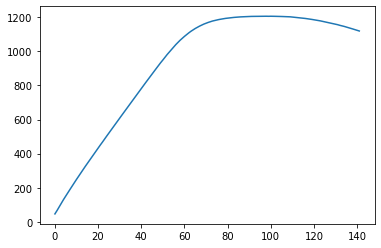

In [12]:
def force_extractor(series):
    series=series.copy()
    force=[]
    for i in series.index:
        series[i]=series[i][0][0]

    return(series)
#display(force_extractor(tests_df.loc['MC_A_6xiii_clipped_cut_lined','data'][(     'add_data',    'analog_channels')]))
tests_df['force']= [force_extractor(tests_df.loc[i,'data'][(     'add_data',    'analog_channels')]*60000) for i in tests_df.index]
mapper={8:25,6:20}##Martin nach genauen Maßen fragen
tests_df['plate_width']=tests_df.plate_thickness.astype(int).map(mapper)
tests_df['sample_crossection']=tests_df['plate_width']*tests_df.plate_thickness.astype(int)
tests_df['stress']=[[f/tests_df.loc[i,'sample_crossection']for f in tests_df.loc[i,'force']] for i in tests_df.index]
plt.plot(tests_df.stress[0])
#plt.plot(tests_df.force[0])
#plt.plot(tests_df.plate_width)
from scipy.signal import savgol_filter as savgol
#plt.plot(savgol(tests_df['25_27  _strain_p1'][0],51,4),tests_df['stress'][0])
#plt.plot(tests_df['25_27  _strain_p1'][0],tests_df['stress'][0])

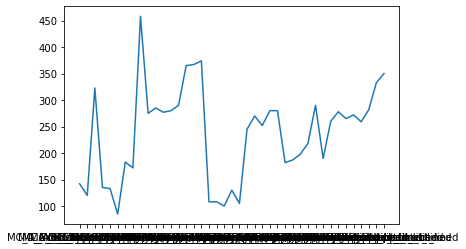

In [13]:
tests_df['data_len']=[len(tests_df.loc[i,'data']) for i in tests_df.index]
plt.plot(tests_df.data_len)

In [14]:
display(tests_df.columns)


Index(['paths', 'ok', 'crack', 'pos', 'left_12-5', 'step_start', 'step_stop',
       'index', 'material', 'senergie/GW', 'plate_thickness', 'testspeed',
       'running_number', 'data', '-35_-33_idxs', '-33_-31_idxs',
       '-31_-29_idxs', '-29_-27_idxs', '-27_-25_idxs', '-25_-23_idxs',
       '-23_-21_idxs', '-21_-19_idxs', '-19_-17_idxs', '-17_-15_idxs',
       '-15_-13_idxs', '-13_-11_idxs', '-11_-9 _idxs', '-9_-7  _idxs',
       '-7_-5  _idxs', '-5_-3  _idxs', '-3_-1  _idxs', '-1_1   _idxs',
       '1_3    _idxs', '3_5    _idxs', '5_7    _idxs', '7_9    _idxs',
       '9_11   _idxs', '11_13  _idxs', '13_15  _idxs', '15_17  _idxs',
       '17_19  _idxs', '19_21  _idxs', '21_23  _idxs', '23_25  _idxs',
       '25_27  _idxs', '27_29  _idxs', '29_31  _idxs', '31_33  _idxs',
       '33_35  _idxs', '-35_-33_strain_p1', '-33_-31_strain_p1',
       '-31_-29_strain_p1', '-29_-27_strain_p1', '-27_-25_strain_p1',
       '-25_-23_strain_p1', '-23_-21_strain_p1', '-21_-19_strain_p1',
       '-

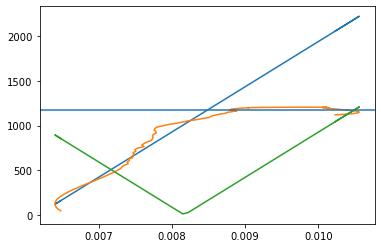

c:\temp\TEMP_U~1/ipykernel_30424/3489956054.py:69: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tests_df['-3_-1  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-3_-1  _strain_p1']))[0] for i in tests_df.index]
c:\temp\TEMP_U~1/ipykernel_30424/3489956054.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  tests_df['-1_1   _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-1_1   _strain_p1']))[0] for i in te

MC_A_6xiii_clipped_cut_lined      [427073.7643967283, -2200.3614753409815]
MC_A_6xi_clipped_cut_lined       [491704.28304005344, -2910.7556987261332]
MC_A_8xiii_clipped_cut_lined       [133120.0355083282, -164.1044848582177]
MC_B_6xiii_clipped_cut_lined     [347203.55059837643, -1461.7671010312138]
MC_B_6xii_clipped_cut_lined        [422709.9094760347, -2319.038439164081]
MC_B_6xi_clipped_cut_lined         [895875.4772664716, -5690.201599176763]
MC_B_8xiii_clipped_cut_lined          [337989.44029977, -1357.30680101446]
MC_B_8xi_clipped_cut_lined        [316045.8291329083, -1512.4648280855681]
MC_B_8yi_clipped_cut_lined       [-2310.672276842705, -28.428842326131168]
MC_GW_6xiii_clipped_cut_lined      [169320.830049105, -1240.6302610595194]
MC_GW_6xi_clipped_cut_lined       [118622.70919097074, -857.6866853258347]
MC_GW_6yiii_clipped_cut_lined      [841896.0707981827, -6685.074951260679]
MC_GW_6yii_clipped_cut_lined       [488253.9019949104, -711.0003351903969]
MC_GW_6yi_clipped_cut_lin

MC_A_6xiii_clipped_cut_lined     1.232911e+03
MC_A_6xi_clipped_cut_lined       1.043972e+03
MC_A_8xiii_clipped_cut_lined     1.211430e+03
MC_B_6xiii_clipped_cut_lined     9.712339e+02
MC_B_6xii_clipped_cut_lined      9.385936e+02
MC_B_6xi_clipped_cut_lined       1.029910e+03
MC_B_8xiii_clipped_cut_lined     9.910834e+02
MC_B_8xi_clipped_cut_lined       9.962223e+02
MC_B_8yi_clipped_cut_lined      -4.527189e+01
MC_GW_6xiii_clipped_cut_lined    1.053247e+03
MC_GW_6xi_clipped_cut_lined      2.222467e+03
MC_GW_6yiii_clipped_cut_lined    1.667084e+03
MC_GW_6yii_clipped_cut_lined     4.932035e+03
MC_GW_6yi_clipped_cut_lined      4.998184e+03
MC_GW_8xi_clipped_cut_lined      1.172509e+03
MC_GW_8yiii_clipped_cut_lined    2.950772e+03
MC_GW_8yii_clipped_cut_lined     3.048839e+03
QL_A_6xiii_clipped_cut_lined     1.003796e+03
QL_A_6xii_clipped_cut_lined      9.372448e+02
QL_A_6xi_clipped_cut_lined       1.151453e+03
QL_A_8xii_clipped_cut_lined      1.167754e+03
QL_A_8xi_clipped_cut_lined       1

MC_A_6xiii_clipped_cut_lined      65
MC_A_6xi_clipped_cut_lined        60
MC_A_8xiii_clipped_cut_lined      89
MC_B_6xiii_clipped_cut_lined      58
MC_B_6xii_clipped_cut_lined       56
MC_B_6xi_clipped_cut_lined        54
MC_B_8xiii_clipped_cut_lined      80
MC_B_8xi_clipped_cut_lined        75
MC_B_8yi_clipped_cut_lined       204
MC_GW_6xiii_clipped_cut_lined     15
MC_GW_6xi_clipped_cut_lined       34
MC_GW_6yiii_clipped_cut_lined     10
MC_GW_6yii_clipped_cut_lined     114
MC_GW_6yi_clipped_cut_lined      235
MC_GW_8xi_clipped_cut_lined       61
MC_GW_8yiii_clipped_cut_lined    121
MC_GW_8yii_clipped_cut_lined     121
QL_A_6xiii_clipped_cut_lined      58
QL_A_6xii_clipped_cut_lined       59
QL_A_6xi_clipped_cut_lined        61
QL_A_8xii_clipped_cut_lined       86
QL_A_8xi_clipped_cut_lined        95
QL_A_8yiii_clipped_cut_lined     165
QL_A_8yiv_clipped_cut_lined        0
QL_A_8yi_clipped_cut_lined       164
QL_A_8yvi_clipped_cut_lined        0
QL_A_8yv_clipped_cut_lined         0
Q

In [15]:
def emod(start,end,stress,strain):
    #print(start,end)
    #print(type(stress),type(strain))
    strain=np.array(strain)
    strainc=strain[range(start,end)]
    stress=np.array(stress)
    stressc=np.array(stress[range(start,end)])
    #plt.plot((strainc),(stressc))
    try:
        z=np.polyfit(list(strainc), list(stressc), 1)
        p=np.poly1d(z)
        emod=z
        n=[p(x) for x in strainc]
        return(emod,n)
    except:
        return ([[180000,5]])
def rp02 (emod,stress,strain):
    df=pd.DataFrame()
    df['stress']=stress
    df['strain']=strain
    df['rpcurve']=(df.strain*emod[0]+emod[1])-(0.002*emod[0])
    idx=df.iloc[(df['stress']-df['rpcurve']).abs().argsort()[:1]].index.tolist()[0]
    #print(idx,df.loc[idx,'stress'],df.loc[idx,'rpcurve'])
    return (df.loc[idx,'rpcurve'],idx)

def smoothing(strain):
    try:
        return(savgol(strain,51,4))
    except:
        return strain

E=emod(0,int(len(tests_df['stress'][0])*0.3),tests_df['stress'][0],savgol(tests_df['25_27  _strain_p1'][0],51,4))[0]
rp=(rp02(E,tests_df['stress'][0],savgol(tests_df['25_27  _strain_p1'][0],51,4))[0])
fig,ax=plt.subplots()
ax.plot(savgol(tests_df['25_27  _strain_p1'][0],51,4),
         [x*E[0]+E[1] for x in savgol(tests_df['25_27  _strain_p1'][0],51,4)]

         )
ax.plot(savgol(tests_df['25_27  _strain_p1'][0],51,4),
         tests_df['stress'][0]

         )
ax.plot(savgol(tests_df['25_27  _strain_p1'][0],51,4),
         [abs((x*E[0]+E[1])-(0.002*E[0])) for x in savgol(tests_df['25_27  _strain_p1'][0],51,4)]

         )
ax.axhline(rp)
plt.show()

#for i in test.index[:-3]:
#    print(i)
#    plt.plot(savgol(tests_df.loc[i,'-33_-31_strain_p1'],41,4))
tests_df['-35_-33_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-35_-33_strain_p1']))[0] for i in tests_df.index]
tests_df['-33_-31_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-33_-31_strain_p1']))[0] for i in tests_df.index]
tests_df['-31_-29_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-31_-29_strain_p1']))[0] for i in tests_df.index]
tests_df['-29_-27_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-29_-27_strain_p1']))[0] for i in tests_df.index]
tests_df['-27_-25_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-27_-25_strain_p1']))[0] for i in tests_df.index]
tests_df['-25_-23_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-25_-23_strain_p1']))[0] for i in tests_df.index]
tests_df['-23_-21_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-23_-21_strain_p1']))[0] for i in tests_df.index]
tests_df['-21_-19_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-21_-19_strain_p1']))[0] for i in tests_df.index]
tests_df['-19_-17_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-19_-17_strain_p1']))[0] for i in tests_df.index]
tests_df['-17_-15_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-17_-15_strain_p1']))[0] for i in tests_df.index]
tests_df['-15_-13_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-15_-13_strain_p1']))[0] for i in tests_df.index]
tests_df['-13_-11_Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-13_-11_strain_p1']))[0] for i in tests_df.index]
tests_df['-11_-9 _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-11_-9 _strain_p1']))[0] for i in tests_df.index]
tests_df['-9_-7  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-9_-7  _strain_p1']))[0] for i in tests_df.index]
tests_df['-7_-5  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-7_-5  _strain_p1']))[0] for i in tests_df.index]
tests_df['-5_-3  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-5_-3  _strain_p1']))[0] for i in tests_df.index]
tests_df['-3_-1  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-3_-1  _strain_p1']))[0] for i in tests_df.index]
tests_df['-1_1   _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-1_1   _strain_p1']))[0] for i in tests_df.index]
tests_df['1_3    _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'1_3    _strain_p1']))[0] for i in tests_df.index]
tests_df['3_5    _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'3_5    _strain_p1']))[0] for i in tests_df.index]
tests_df['5_7    _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'5_7    _strain_p1']))[0] for i in tests_df.index]
tests_df['7_9    _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'7_9    _strain_p1']))[0] for i in tests_df.index]
tests_df['9_11   _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'9_11   _strain_p1']))[0] for i in tests_df.index]
tests_df['11_13  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'11_13  _strain_p1']))[0] for i in tests_df.index]
tests_df['13_15  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'13_15  _strain_p1']))[0] for i in tests_df.index]
tests_df['15_17  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'15_17  _strain_p1']))[0] for i in tests_df.index]
tests_df['17_19  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'17_19  _strain_p1']))[0] for i in tests_df.index]
tests_df['19_21  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'19_21  _strain_p1']))[0] for i in tests_df.index]
tests_df['21_23  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'21_23  _strain_p1']))[0] for i in tests_df.index]
tests_df['23_25  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'23_25  _strain_p1']))[0] for i in tests_df.index]
tests_df['25_27  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'25_27  _strain_p1']))[0] for i in tests_df.index]
tests_df['27_29  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'27_29  _strain_p1']))[0] for i in tests_df.index]
tests_df['29_31  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'29_31  _strain_p1']))[0] for i in tests_df.index]
tests_df['31_33  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'31_33  _strain_p1']))[0] for i in tests_df.index]
tests_df['33_35  _Emod']  = [emod(5,int(len(tests_df.loc[i,'stress'])*0.3),tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'33_35  _strain_p1']))[0] for i in tests_df.index]

display(tests_df['5_7    _Emod'])
tests_df=tests_df.copy()
tests_df['-35_-33_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-35_-33_strain_p1']))[0] for i in tests_df.index]
tests_df['-33_-31_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-33_-31_strain_p1']))[0] for i in tests_df.index]
tests_df['-31_-29_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-31_-29_strain_p1']))[0] for i in tests_df.index]
tests_df['-29_-27_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-29_-27_strain_p1']))[0] for i in tests_df.index]
tests_df['-27_-25_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-27_-25_strain_p1']))[0] for i in tests_df.index]
tests_df['-25_-23_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-25_-23_strain_p1']))[0] for i in tests_df.index]
tests_df['-23_-21_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-23_-21_strain_p1']))[0] for i in tests_df.index]
tests_df['-21_-19_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-21_-19_strain_p1']))[0] for i in tests_df.index]
tests_df['-19_-17_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-19_-17_strain_p1']))[0] for i in tests_df.index]
tests_df['-17_-15_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-17_-15_strain_p1']))[0] for i in tests_df.index]
tests_df['-15_-13_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-15_-13_strain_p1']))[0] for i in tests_df.index]
tests_df['-13_-11_rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-13_-11_strain_p1']))[0] for i in tests_df.index]
tests_df['-11_-9 _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-11_-9 _strain_p1']))[0] for i in tests_df.index]
tests_df['-9_-7  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-9_-7  _strain_p1']))[0] for i in tests_df.index]
tests_df['-7_-5  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-7_-5  _strain_p1']))[0] for i in tests_df.index]
tests_df['-5_-3  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-5_-3  _strain_p1']))[0] for i in tests_df.index]
tests_df['-3_-1  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-3_-1  _strain_p1']))[0] for i in tests_df.index]
tests_df['-1_1   _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-1_1   _strain_p1']))[0] for i in tests_df.index]
tests_df['1_3    _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'1_3    _strain_p1']))[0] for i in tests_df.index]
tests_df['3_5    _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'3_5    _strain_p1']))[0] for i in tests_df.index]
tests_df['5_7    _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'5_7    _strain_p1']))[0] for i in tests_df.index]
tests_df['7_9    _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'7_9    _strain_p1']))[0] for i in tests_df.index]
tests_df['9_11   _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'9_11   _strain_p1']))[0] for i in tests_df.index]
tests_df['11_13  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'11_13  _strain_p1']))[0] for i in tests_df.index]
tests_df['13_15  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'13_15  _strain_p1']))[0] for i in tests_df.index]
tests_df['15_17  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'15_17  _strain_p1']))[0] for i in tests_df.index]
tests_df['17_19  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'17_19  _strain_p1']))[0] for i in tests_df.index]
tests_df['19_21  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'19_21  _strain_p1']))[0] for i in tests_df.index]
tests_df['21_23  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'21_23  _strain_p1']))[0] for i in tests_df.index]
tests_df['23_25  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'23_25  _strain_p1']))[0] for i in tests_df.index]
tests_df['25_27  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'25_27  _strain_p1']))[0] for i in tests_df.index]
tests_df['27_29  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'27_29  _strain_p1']))[0] for i in tests_df.index]
tests_df['29_31  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'29_31  _strain_p1']))[0] for i in tests_df.index]
tests_df['31_33  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'31_33  _strain_p1']))[0] for i in tests_df.index]
tests_df['33_35  _rp02']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'33_35  _strain_p1']))[0] for i in tests_df.index]
tests_df=tests_df.copy()
display(tests_df['5_7    _rp02'])
def rp02_idx(tests_df):
    tests_df['-35_-33_rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-35_-33_strain_p1']))[1] for i in tests_df.index]
    tests_df['-33_-31_rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-33_-31_strain_p1']))[1] for i in tests_df.index]
    tests_df['-31_-29_rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-31_-29_strain_p1']))[1] for i in tests_df.index]
    tests_df['-29_-27_rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-29_-27_strain_p1']))[1] for i in tests_df.index]
    tests_df['-27_-25_rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-27_-25_strain_p1']))[1] for i in tests_df.index]
    tests_df['-25_-23_rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-25_-23_strain_p1']))[1] for i in tests_df.index]
    tests_df['-23_-21_rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-23_-21_strain_p1']))[1] for i in tests_df.index]
    tests_df['-21_-19_rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-21_-19_strain_p1']))[1] for i in tests_df.index]
    tests_df['-19_-17_rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-19_-17_strain_p1']))[1] for i in tests_df.index]
    tests_df['-17_-15_rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-17_-15_strain_p1']))[1] for i in tests_df.index]
    tests_df['-15_-13_rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-15_-13_strain_p1']))[1] for i in tests_df.index]
    tests_df['-13_-11_rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-13_-11_strain_p1']))[1] for i in tests_df.index]
    tests_df['-11_-9 _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-11_-9 _strain_p1']))[1] for i in tests_df.index]
    tests_df['-9_-7  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-9_-7  _strain_p1']))[1] for i in tests_df.index]
    tests_df['-7_-5  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-7_-5  _strain_p1']))[1] for i in tests_df.index]
    tests_df['-5_-3  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-5_-3  _strain_p1']))[1] for i in tests_df.index]
    tests_df['-3_-1  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-3_-1  _strain_p1']))[1] for i in tests_df.index]
    tests_df['-1_1   _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'-1_1   _strain_p1']))[1] for i in tests_df.index]
    tests_df['1_3    _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'1_3    _strain_p1']))[1] for i in tests_df.index]
    tests_df['3_5    _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'3_5    _strain_p1']))[1] for i in tests_df.index]
    tests_df['5_7    _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'5_7    _strain_p1']))[1] for i in tests_df.index]
    tests_df['7_9    _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'7_9    _strain_p1']))[1] for i in tests_df.index]
    tests_df['9_11   _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'9_11   _strain_p1']))[1] for i in tests_df.index]
    tests_df['11_13  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'11_13  _strain_p1']))[1] for i in tests_df.index]
    tests_df['13_15  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'13_15  _strain_p1']))[1] for i in tests_df.index]
    tests_df['15_17  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'15_17  _strain_p1']))[1] for i in tests_df.index]
    tests_df['17_19  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'17_19  _strain_p1']))[1] for i in tests_df.index]
    tests_df['19_21  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'19_21  _strain_p1']))[1] for i in tests_df.index]
    tests_df['21_23  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'21_23  _strain_p1']))[1] for i in tests_df.index]
    tests_df['23_25  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'23_25  _strain_p1']))[1] for i in tests_df.index]
    tests_df['25_27  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'25_27  _strain_p1']))[1] for i in tests_df.index]
    tests_df['27_29  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'27_29  _strain_p1']))[1] for i in tests_df.index]
    tests_df['29_31  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'29_31  _strain_p1']))[1] for i in tests_df.index]
    tests_df['31_33  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'31_33  _strain_p1']))[1] for i in tests_df.index]
    tests_df['33_35  _rp02_idx']  = [rp02(E,tests_df.loc[i,'stress'],smoothing(tests_df.loc[i,'33_35  _strain_p1']))[1] for i in tests_df.index]
    tests_df=tests_df.copy()
    display(tests_df['5_7    _rp02_idx'])
    return(tests_df)
tests_df=rp02_idx(tests_df)
#def meaner (series):
#    means=[]
#    for

In [24]:
for i in tests_df.columns:

    display(i,tests_df.loc['QL_B_8yiv_clipped_cut_lined',i])


'paths'

'Y:\\Istra Repositories\\ch-gr_exports\\QL_B_8yiv_clipped_cut_lined.pickle'

'ok'

1.0

'crack'

145.0

'pos'

135.0

'left_12-5'

115.0

'step_start'

100.0

'step_stop'

390.0

'index'

'QL_B_8yiv_clipped_cut_lined'

'material'

'QL'

'senergie/GW'

'B'

'plate_thickness'

'8'

'testspeed'

'y'

'running_number'

'iv'

'data'

group                                                              add_data  \
dataset                                                     analog_channels   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  [[0.10637512404247841]]   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  [[0.11985606834534716]]   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...   [[0.1330082092059294]]   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  [[0.14550274309557784]]   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...   [[0.1593124911621832]]   
...                                                                     ...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...   [[3.7136865224980413]]   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...   [[3.7110560789194054]]   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...    [[3.709083246248234]]   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...    [[3.706781608145733]]   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...   [[3.7054663863795767]]   

group                                                                                     coordinates  \
dataset                                                                                  coordinate_x   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2     -2.032726
3     -2.055891
4     -2.07932...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2     -2.033182
3     -2.056119
4     -2.07959...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2     -2.033273
3     -2.056319
4     -2.07967...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2     -2.032717
3     -2.055824
4     -2.07908...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2     -2.033140
3     -2.056232
4     -2.07935...   
...                                                                                               ...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2      0.000000
3      0.000000
4      0.00000...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2      0.000000
3      0.000000
4      0.00000...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2      0.000000
3      0.000000
4      0.00000...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2      0.000000
3      0.000000
4      0.00000...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2      0.000000
3      0.000000
4      0.00000...   

group                                                                                                  \
dataset                                                                                  coordinate_y   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2      56.389032
3      55.954140
4      55.51...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2      56.398970
3      55.964299
4      55.52...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2      56.408561
3      55.973012
4      55.53...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2      56.418988
3      55.983306
4      55.54...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2      56.428071
3      55.992558
4      55.55...   
...                                                                                               ...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2       0.000000
3       0.000000
4       0.00...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2       0.000000
3       0.000000
4       0.00...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2       0.000000
3       0.000000
4       0.00...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2       0.000000
3       0.000000
4       0.00...   
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\s...  2       0.000000
3       0.000000
4       0.00...   

group                                                                                                  \
dataset                                                                                  coordinate_z   
Y:\Istra Repositories\ch-gr_ex

'-35_-33_idxs'

(135, 58, 63)

'-33_-31_idxs'

(135, 63, 67)

'-31_-29_idxs'

(135, 67, 71)

'-29_-27_idxs'

(135, 71, 76)

'-27_-25_idxs'

(135, 76, 80)

'-25_-23_idxs'

(135, 80, 84)

'-23_-21_idxs'

(135, 84, 89)

'-21_-19_idxs'

(135, 89, 93)

'-19_-17_idxs'

(135, 93, 98)

'-17_-15_idxs'

(135, 98, 102)

'-15_-13_idxs'

(135, 102, 106)

'-13_-11_idxs'

(135, 106, 111)

'-11_-9 _idxs'

(135, 111, 115)

'-9_-7  _idxs'

(135, 115, 120)

'-7_-5  _idxs'

(135, 120, 124)

'-5_-3  _idxs'

(135, 124, 128)

'-3_-1  _idxs'

(135, 128, 133)

'-1_1   _idxs'

(135, 133, 137)

'1_3    _idxs'

(135, 137, 142)

'3_5    _idxs'

(135, 142, 146)

'5_7    _idxs'

(135, 146, 150)

'7_9    _idxs'

(135, 150, 155)

'9_11   _idxs'

(135, 155, 159)

'11_13  _idxs'

(135, 159, 164)

'13_15  _idxs'

(135, 164, 168)

'15_17  _idxs'

(135, 168, 173)

'17_19  _idxs'

(135, 173, 177)

'19_21  _idxs'

(135, 177, 181)

'21_23  _idxs'

(135, 181, 186)

'23_25  _idxs'

(135, 186, 190)

'25_27  _idxs'

(135, 190, 195)

'27_29  _idxs'

(135, 195, 199)

'29_31  _idxs'

(135, 199, 199)

'31_33  _idxs'

(135, 199, 199)

'33_35  _idxs'

(135, 199, 199)

'-35_-33_strain_p1'

[2.1819589138031006,
 2.214233636856079,
 2.4509119987487793,
 2.4141809940338135,
 2.3979411125183105,
 2.1600921154022217,
 2.295853614807129,
 2.2159230709075928,
 2.520782470703125,
 2.492932081222534,
 2.20389986038208,
 2.5740957260131836,
 2.2980191707611084,
 2.2701361179351807,
 2.4202988147735596,
 2.434894323348999,
 2.479445695877075,
 2.3501102924346924,
 2.664525270462036,
 2.5518147945404053,
 2.461761474609375,
 2.7145309448242188,
 2.485318183898926,
 2.711357831954956,
 2.682415008544922,
 2.4231226444244385,
 2.850933074951172,
 2.530900716781616,
 2.700620651245117,
 2.5416605472564697,
 2.610570192337036,
 2.4918711185455322,
 2.502861976623535,
 2.7955331802368164,
 2.8068058490753174,
 2.8288958072662354,
 2.500540018081665,
 2.6008076667785645,
 2.8121097087860107,
 2.7593748569488525,
 2.603001356124878,
 2.755131959915161,
 2.8535354137420654,
 2.8806846141815186,
 2.7187020778656006,
 3.239811897277832,
 3.2266314029693604,
 2.9359352588653564,
 3.15812945365

'-33_-31_strain_p1'

[2.068028450012207,
 2.1711294651031494,
 2.4863736629486084,
 1.9233375787734985,
 2.1901469230651855,
 1.9883339405059814,
 2.2201220989227295,
 2.0922720432281494,
 2.286468744277954,
 2.4554038047790527,
 2.202895164489746,
 2.151660203933716,
 2.0570566654205322,
 2.1466078758239746,
 2.366240978240967,
 2.617645263671875,
 2.3652195930480957,
 2.187464952468872,
 2.4515652656555176,
 2.377861738204956,
 2.521484375,
 2.5021417140960693,
 2.5824482440948486,
 2.406282663345337,
 3.0086026191711426,
 2.6354198455810547,
 2.888174533843994,
 2.707017421722412,
 2.4403913021087646,
 2.667546510696411,
 2.666163444519043,
 2.4048094749450684,
 2.5539534091949463,
 2.6806235313415527,
 2.799590587615967,
 2.6502013206481934,
 2.5446927547454834,
 2.6045730113983154,
 2.6432719230651855,
 2.8669745922088623,
 2.800997495651245,
 2.557405471801758,
 2.376138687133789,
 2.871865749359131,
 2.7347357273101807,
 2.933166742324829,
 3.053968906402588,
 3.0200436115264893,
 2.728546619415283,

'-31_-29_strain_p1'

[1.918752670288086,
 1.9278862476348877,
 1.9248602390289307,
 2.0725302696228027,
 2.2626607418060303,
 1.6201629638671875,
 1.922753930091858,
 2.0301780700683594,
 2.09883189201355,
 2.1322927474975586,
 2.362666368484497,
 2.156066417694092,
 2.070573329925537,
 2.209693431854248,
 2.2035975456237793,
 2.0115630626678467,
 2.676891803741455,
 2.2516651153564453,
 2.330228328704834,
 2.240455150604248,
 2.59850811958313,
 2.4828941822052,
 2.218663215637207,
 2.3907053470611572,
 2.8638782501220703,
 2.5437026023864746,
 2.5817577838897705,
 2.837916851043701,
 2.658339023590088,
 2.904567003250122,
 2.902773380279541,
 2.930878162384033,
 2.963636636734009,
 2.7337870597839355,
 2.626988172531128,
 2.547759532928467,
 2.7207212448120117,
 2.782029867172241,
 2.432279109954834,
 2.817535400390625,
 2.817939043045044,
 2.425544500350952,
 2.2281692028045654,
 2.8853297233581543,
 2.655238389968872,
 2.459777355194092,
 3.2728965282440186,
 3.1319804191589355,
 2.9142215251922607,
 2.

'-29_-27_strain_p1'

[1.6281976699829102,
 1.786412239074707,
 1.7442482709884644,
 2.0956850051879883,
 2.2109811305999756,
 2.0590627193450928,
 2.164386510848999,
 1.8446398973464966,
 2.143228769302368,
 1.7346230745315552,
 2.1572234630584717,
 2.2584192752838135,
 2.2278823852539062,
 2.1153059005737305,
 2.2464239597320557,
 2.2522923946380615,
 2.1148521900177,
 2.373201608657837,
 1.9790643453598022,
 2.4899799823760986,
 2.346514940261841,
 2.3301732540130615,
 2.1570301055908203,
 2.589960813522339,
 2.396467685699463,
 2.0061416625976562,
 2.2265641689300537,
 2.1770870685577393,
 2.385807752609253,
 2.251450538635254,
 2.5835177898406982,
 2.7564468383789062,
 2.648347854614258,
 2.365429639816284,
 2.349872589111328,
 2.4121105670928955,
 2.094581365585327,
 2.694930076599121,
 2.577690839767456,
 2.637319803237915,
 2.711247444152832,
 2.572603225708008,
 2.718205213546753,
 2.783512830734253,
 2.6317050457000732,
 2.4060211181640625,
 2.5831096172332764,
 2.7755439281463623,
 2.898597717285

'-27_-25_strain_p1'

[2.532012462615967,
 1.9506438970565796,
 2.4496264457702637,
 2.51008939743042,
 1.8442386388778687,
 2.5028493404388428,
 2.525195837020874,
 2.28218412399292,
 2.3325467109680176,
 2.5061397552490234,
 2.1308414936065674,
 2.5164594650268555,
 2.089447498321533,
 2.4375290870666504,
 2.7411415576934814,
 2.7496373653411865,
 2.311906337738037,
 2.3786094188690186,
 2.019681215286255,
 2.2764620780944824,
 2.299316644668579,
 2.7512869834899902,
 2.594735622406006,
 2.663756847381592,
 2.3698372840881348,
 2.2811737060546875,
 2.7227699756622314,
 2.437429666519165,
 2.432999849319458,
 2.813913345336914,
 2.7140088081359863,
 2.7409324645996094,
 2.6316394805908203,
 2.9618823528289795,
 2.7199130058288574,
 2.6640048027038574,
 2.586007833480835,
 2.6866612434387207,
 2.7621347904205322,
 3.1441588401794434,
 2.804612636566162,
 3.1700170040130615,
 3.2344467639923096,
 3.4188015460968018,
 3.134326219558716,
 2.6748557090759277,
 3.1576924324035645,
 2.9731392860412598,
 2.8274931

'-25_-23_strain_p1'

[1.986321210861206,
 1.4829038381576538,
 2.0648698806762695,
 2.1900782585144043,
 2.1344096660614014,
 2.305424213409424,
 2.473723888397217,
 2.3033363819122314,
 2.245291233062744,
 2.6321654319763184,
 2.480057954788208,
 2.3483853340148926,
 2.440680980682373,
 2.4456536769866943,
 2.218949794769287,
 2.411529541015625,
 2.741483449935913,
 2.2722113132476807,
 2.2061946392059326,
 2.236386775970459,
 2.064910888671875,
 2.364154100418091,
 2.480067253112793,
 2.2465908527374268,
 2.168347120285034,
 2.3972420692443848,
 2.534255027770996,
 2.650470018386841,
 2.569920063018799,
 2.8412678241729736,
 2.2528276443481445,
 2.614262104034424,
 2.57132625579834,
 2.9007067680358887,
 2.6903152465820312,
 2.768523931503296,
 2.230879783630371,
 2.476860523223877,
 2.783503770828247,
 2.71046781539917,
 2.3936476707458496,
 2.577824115753174,
 2.581305980682373,
 2.784325122833252,
 2.685515880584717,
 2.617525577545166,
 3.059115409851074,
 2.7961552143096924,
 2.677769184112549,
 2.9

'-23_-21_strain_p1'

[2.3046369552612305,
 2.0232009887695312,
 2.445706367492676,
 2.6193339824676514,
 2.340857744216919,
 2.2485897541046143,
 2.3582863807678223,
 2.244203567504883,
 2.5775959491729736,
 2.261967420578003,
 2.146608352661133,
 2.46627140045166,
 2.35589599609375,
 2.2259697914123535,
 2.326366424560547,
 2.623809576034546,
 2.450558662414551,
 2.3926336765289307,
 2.0540060997009277,
 2.373573064804077,
 2.3498754501342773,
 2.147066354751587,
 2.1355414390563965,
 2.5063095092773438,
 2.0595359802246094,
 2.371392250061035,
 2.563213348388672,
 2.50732684135437,
 2.5313260555267334,
 2.555307626724243,
 2.5894575119018555,
 2.3318607807159424,
 2.6791698932647705,
 2.6365597248077393,
 2.3324406147003174,
 2.5131676197052,
 2.66152024269104,
 2.57531476020813,
 2.857428789138794,
 2.7806241512298584,
 2.614271879196167,
 3.0563948154449463,
 2.5059444904327393,
 2.7709531784057617,
 2.8609039783477783,
 2.713636636734009,
 2.95780873298645,
 2.831636667251587,
 2.9077701568603516,
 2.

'-21_-19_strain_p1'

[2.0522875785827637,
 2.2586634159088135,
 2.2749578952789307,
 2.5074896812438965,
 2.5735771656036377,
 1.7680599689483643,
 2.100269079208374,
 2.025339126586914,
 2.3857076168060303,
 2.364379405975342,
 2.272580862045288,
 2.0383636951446533,
 2.2169594764709473,
 2.0259549617767334,
 2.0281803607940674,
 2.57603120803833,
 2.316004753112793,
 2.427130699157715,
 1.992640495300293,
 2.406628370285034,
 1.9548803567886353,
 2.2564544677734375,
 2.477618455886841,
 2.163693904876709,
 2.02632474899292,
 2.453528642654419,
 2.234931230545044,
 2.321282148361206,
 2.4609782695770264,
 2.6063292026519775,
 2.6467502117156982,
 2.4336743354797363,
 2.5374886989593506,
 2.415989398956299,
 2.7157859802246094,
 2.5884430408477783,
 2.8846969604492188,
 2.6121907234191895,
 2.0523605346679688,
 2.49593186378479,
 2.3417880535125732,
 2.729529857635498,
 2.676302909851074,
 2.6406681537628174,
 2.7149176597595215,
 2.7290050983428955,
 2.855513334274292,
 2.6762287616729736,
 2.930230617523

'-19_-17_strain_p1'

[1.8233904838562012,
 2.1051056385040283,
 2.3901214599609375,
 2.0767221450805664,
 1.9118391275405884,
 1.8565565347671509,
 2.167057752609253,
 2.015301465988159,
 2.3629791736602783,
 2.292091131210327,
 2.4811789989471436,
 2.0322368144989014,
 2.240647554397583,
 2.1023831367492676,
 2.108464241027832,
 2.534062623977661,
 2.373474597930908,
 2.4187443256378174,
 2.220609188079834,
 2.2460086345672607,
 2.372220993041992,
 2.55659556388855,
 2.319537401199341,
 2.640281915664673,
 2.3260109424591064,
 2.2326481342315674,
 2.011605739593506,
 2.6786928176879883,
 2.5093390941619873,
 2.7384135723114014,
 2.660750389099121,
 2.221207857131958,
 2.4772307872772217,
 2.367866277694702,
 2.6774046421051025,
 2.5423436164855957,
 2.8059370517730713,
 2.0679914951324463,
 2.389448642730713,
 2.44004487991333,
 2.933624029159546,
 2.5772602558135986,
 2.6677448749542236,
 2.778712272644043,
 2.4009034633636475,
 2.806790590286255,
 2.8253285884857178,
 2.7016189098358154,
 2.800404310226

'-17_-15_strain_p1'

[2.39874005317688,
 2.1930832862854004,
 2.600917339324951,
 2.633495569229126,
 2.5374372005462646,
 2.4004580974578857,
 2.5492429733276367,
 2.283297538757324,
 2.57940673828125,
 2.653480052947998,
 2.534503936767578,
 2.366299867630005,
 2.7223191261291504,
 2.621391534805298,
 2.790363311767578,
 2.71537184715271,
 2.894622325897217,
 2.9367830753326416,
 2.505112886428833,
 2.76676607131958,
 2.612637519836426,
 2.8705649375915527,
 2.815359115600586,
 2.8465142250061035,
 2.7224419116973877,
 2.4427361488342285,
 2.7659733295440674,
 2.5584962368011475,
 2.828151226043701,
 2.9666128158569336,
 3.011784553527832,
 2.7744483947753906,
 3.295724868774414,
 2.614729404449463,
 3.0660152435302734,
 3.324789524078369,
 3.0985708236694336,
 3.080622673034668,
 3.069152593612671,
 3.2538483142852783,
 3.256932497024536,
 3.166778087615967,
 2.9558188915252686,
 3.019369602203369,
 2.852707624435425,
 2.9918484687805176,
 3.12302303314209,
 3.328190565109253,
 3.3693175315856934,
 3.44

'-15_-13_strain_p1'

[2.036369562149048,
 2.208474636077881,
 2.21108341217041,
 2.286811113357544,
 2.6119611263275146,
 2.130580186843872,
 2.2182793617248535,
 2.318828582763672,
 2.315133571624756,
 2.054551362991333,
 2.325117588043213,
 2.3020405769348145,
 2.327552080154419,
 2.210960626602173,
 1.8598248958587646,
 2.3188459873199463,
 2.1982321739196777,
 2.3298370838165283,
 2.1646759510040283,
 2.289813280105591,
 2.27128267288208,
 2.329470634460449,
 2.420748472213745,
 2.6528077125549316,
 2.4236624240875244,
 2.2770676612854004,
 2.538355588912964,
 2.5120010375976562,
 2.386221408843994,
 2.617281675338745,
 2.623014450073242,
 2.568270206451416,
 2.64786696434021,
 1.900031328201294,
 2.448517322540283,
 3.1664321422576904,
 2.8352506160736084,
 2.4543511867523193,
 2.464707612991333,
 3.0803322792053223,
 2.707925319671631,
 2.8157379627227783,
 2.5984463691711426,
 2.8376073837280273,
 2.5992400646209717,
 2.674706220626831,
 2.700636148452759,
 2.884638786315918,
 2.397352695465088,
 3.

'-13_-11_strain_p1'

[2.0968992710113525,
 2.01896071434021,
 2.313192367553711,
 2.1988377571105957,
 2.1345114707946777,
 1.9240431785583496,
 1.7171660661697388,
 2.359323263168335,
 1.974666953086853,
 2.0926902294158936,
 2.0713934898376465,
 1.9850162267684937,
 2.208456516265869,
 2.1842286586761475,
 1.9766288995742798,
 2.2607574462890625,
 2.1676669120788574,
 2.1710431575775146,
 2.331132173538208,
 1.8691209554672241,
 2.0990164279937744,
 2.1826601028442383,
 2.5509445667266846,
 2.46479868888855,
 2.3907105922698975,
 2.433114767074585,
 2.51428484916687,
 2.4814202785491943,
 2.1984357833862305,
 2.8409197330474854,
 2.480379819869995,
 2.510953187942505,
 2.3276565074920654,
 2.168966054916382,
 2.6881420612335205,
 3.003253698348999,
 2.4831016063690186,
 2.1761276721954346,
 2.325035810470581,
 2.705251455307007,
 2.4264259338378906,
 2.33581805229187,
 2.478808879852295,
 2.5999252796173096,
 2.432147979736328,
 2.2828800678253174,
 2.54441237449646,
 2.740431785583496,
 2.64141130447387

'-11_-9 _strain_p1'

[2.3425230979919434,
 2.1926450729370117,
 2.346222400665283,
 2.4459426403045654,
 2.564053773880005,
 2.1068954467773438,
 2.0826964378356934,
 2.6119163036346436,
 2.350979804992676,
 2.2384657859802246,
 2.330054759979248,
 2.464448928833008,
 2.2845544815063477,
 2.4101290702819824,
 2.3681304454803467,
 2.6390140056610107,
 2.2609481811523438,
 2.4701411724090576,
 2.2046456336975098,
 2.3451924324035645,
 2.6474006175994873,
 2.378603458404541,
 2.615309000015259,
 2.5799527168273926,
 2.5649046897888184,
 2.7312119007110596,
 2.2450244426727295,
 2.522332191467285,
 2.7149055004119873,
 2.8982601165771484,
 2.6389174461364746,
 2.759505271911621,
 2.857168674468994,
 2.4697518348693848,
 2.8770506381988525,
 2.7006092071533203,
 2.6794593334198,
 2.783435106277466,
 2.6431527137756348,
 3.0867791175842285,
 2.6734778881073,
 2.886103391647339,
 3.2936489582061768,
 2.8688790798187256,
 3.0435221195220947,
 2.711064338684082,
 2.9114694595336914,
 3.270540952682495,
 2.728209018

'-9_-7  _strain_p1'

[2.143355131149292,
 1.956274390220642,
 2.086172342300415,
 2.2165496349334717,
 2.0061261653900146,
 2.0025393962860107,
 2.08225417137146,
 2.1864476203918457,
 2.2026607990264893,
 2.0383787155151367,
 1.9687390327453613,
 2.3678410053253174,
 2.4682657718658447,
 2.3784897327423096,
 2.152243137359619,
 2.258931875228882,
 2.3704864978790283,
 2.596723794937134,
 2.1484835147857666,
 2.480886459350586,
 2.185389518737793,
 2.304189443588257,
 2.5163211822509766,
 2.6722259521484375,
 2.2410218715667725,
 2.5749905109405518,
 2.4292685985565186,
 2.2400853633880615,
 2.275799512863159,
 2.705949068069458,
 2.618037700653076,
 2.3846633434295654,
 2.3554046154022217,
 2.6761014461517334,
 2.502626657485962,
 2.6168975830078125,
 2.730252981185913,
 2.6471197605133057,
 2.428941488265991,
 2.759021520614624,
 2.6815860271453857,
 2.7178220748901367,
 3.054471254348755,
 2.6303141117095947,
 2.716567277908325,
 2.625507354736328,
 2.701078176498413,
 2.9637317657470703,
 2.98587298393

'-7_-5  _strain_p1'

[2.6345467567443848,
 2.484506368637085,
 2.1225712299346924,
 2.4435513019561768,
 2.199540138244629,
 2.5330424308776855,
 2.3942275047302246,
 2.502237319946289,
 2.208102226257324,
 2.19097900390625,
 2.561384677886963,
 2.4267890453338623,
 2.4110004901885986,
 2.625072956085205,
 2.8241467475891113,
 2.470133066177368,
 2.387279987335205,
 2.4474902153015137,
 2.808302164077759,
 2.6073901653289795,
 2.721442461013794,
 2.6610608100891113,
 3.027194023132324,
 2.4733293056488037,
 2.7671923637390137,
 2.5176477432250977,
 2.904224157333374,
 2.77854323387146,
 2.918328285217285,
 2.651768684387207,
 3.1793084144592285,
 2.705977201461792,
 2.735975742340088,
 2.7117228507995605,
 2.600651264190674,
 3.1080121994018555,
 2.833178758621216,
 3.099916934967041,
 3.049889087677002,
 2.801053524017334,
 2.737366199493408,
 3.132575273513794,
 3.0168004035949707,
 3.087506055831909,
 3.138983726501465,
 3.0400230884552,
 2.9945361614227295,
 3.1422677040100098,
 3.3628830909729004,
 2.

'-5_-3  _strain_p1'

[2.26168155670166,
 1.9735491275787354,
 2.3265140056610107,
 1.9941370487213135,
 2.436983346939087,
 2.1919760704040527,
 2.4070215225219727,
 2.6408324241638184,
 2.663222551345825,
 2.3933823108673096,
 2.477602005004883,
 2.5097484588623047,
 2.2665598392486572,
 2.4346039295196533,
 2.6229207515716553,
 2.6024813652038574,
 2.659745693206787,
 2.450709581375122,
 2.3949294090270996,
 2.642195701599121,
 2.7287895679473877,
 2.779832601547241,
 3.0045604705810547,
 2.749119520187378,
 2.531846761703491,
 2.6070733070373535,
 2.7929842472076416,
 2.369178295135498,
 2.5901219844818115,
 2.5789794921875,
 2.9365878105163574,
 3.0204901695251465,
 2.8840155601501465,
 3.1125576496124268,
 2.947831869125366,
 3.305413007736206,
 2.7732207775115967,
 3.4524898529052734,
 2.763899087905884,
 2.8247230052948,
 2.8899118900299072,
 3.2304718494415283,
 3.138979434967041,
 3.1215927600860596,
 2.8724820613861084,
 2.930626630783081,
 3.233264923095703,
 3.275862216949463,
 3.60744905471801

'-3_-1  _strain_p1'

[2.257878541946411,
 2.428680181503296,
 2.3269269466400146,
 2.4008970260620117,
 2.3656842708587646,
 2.3744959831237793,
 2.3706581592559814,
 2.4461824893951416,
 2.213265895843506,
 2.5997507572174072,
 2.5829732418060303,
 2.487644910812378,
 2.516772747039795,
 2.4846444129943848,
 2.47527813911438,
 2.6234185695648193,
 2.554398775100708,
 2.6355655193328857,
 2.6861331462860107,
 3.0434341430664062,
 2.5001370906829834,
 2.738926649093628,
 2.6659486293792725,
 3.1668918132781982,
 2.7195093631744385,
 2.9261882305145264,
 2.864299774169922,
 2.642314910888672,
 2.5954368114471436,
 2.782599449157715,
 2.7185306549072266,
 3.0664422512054443,
 3.0328328609466553,
 2.9807322025299072,
 3.046356201171875,
 3.2162675857543945,
 2.4176480770111084,
 2.9519355297088623,
 2.9527499675750732,
 2.9588747024536133,
 3.1630449295043945,
 2.9110820293426514,
 3.067939043045044,
 2.796738624572754,
 2.967042922973633,
 3.0359771251678467,
 3.3135197162628174,
 3.373000144958496,
 3.130550

'-1_1   _strain_p1'

[2.481840133666992,
 2.444061756134033,
 2.3617453575134277,
 2.2921156883239746,
 2.2708866596221924,
 2.2407495975494385,
 2.404289722442627,
 2.1093108654022217,
 2.1751151084899902,
 2.3437705039978027,
 2.3687851428985596,
 2.2061848640441895,
 2.3397340774536133,
 2.376152992248535,
 2.3115997314453125,
 2.293687105178833,
 2.224179983139038,
 1.985481858253479,
 2.346541166305542,
 2.4762306213378906,
 2.118710994720459,
 2.385530471801758,
 2.5863330364227295,
 2.3243567943573,
 2.5317764282226562,
 2.5207462310791016,
 2.7193329334259033,
 2.566096782684326,
 2.417065382003784,
 2.665147542953491,
 2.3986575603485107,
 2.6580207347869873,
 2.868086338043213,
 2.7480392456054688,
 2.9343819618225098,
 2.962663173675537,
 2.805828094482422,
 2.8065149784088135,
 2.8189244270324707,
 2.797581195831299,
 3.158754825592041,
 2.9197778701782227,
 2.643209218978882,
 2.5485353469848633,
 2.642122983932495,
 2.794584035873413,
 3.0217175483703613,
 2.8199918270111084,
 3.0330579280853

'1_3    _strain_p1'

[2.9830493927001953,
 2.3127708435058594,
 2.521026611328125,
 2.862748384475708,
 2.750173807144165,
 2.552217721939087,
 2.564523458480835,
 2.5925662517547607,
 2.3720004558563232,
 3.010806083679199,
 2.51918888092041,
 2.3871352672576904,
 2.610172748565674,
 2.524582624435425,
 2.9261229038238525,
 2.688579797744751,
 2.8948066234588623,
 2.2307112216949463,
 2.402719736099243,
 2.6347339153289795,
 2.524477481842041,
 2.987879991531372,
 2.9855880737304688,
 2.7325494289398193,
 2.494281768798828,
 2.8846731185913086,
 3.1402080059051514,
 2.7353146076202393,
 2.7409706115722656,
 2.996002197265625,
 2.750877618789673,
 3.0949909687042236,
 3.454470634460449,
 3.1170833110809326,
 3.1353347301483154,
 2.859239339828491,
 3.5387790203094482,
 2.9465620517730713,
 2.964938163757324,
 3.1194820404052734,
 3.261807680130005,
 3.331610918045044,
 2.8813316822052,
 3.061041831970215,
 3.0757715702056885,
 3.020400285720825,
 3.320504903793335,
 3.2471511363983154,
 3.605092763900757,


'3_5    _strain_p1'

[3.3693649768829346,
 2.867520809173584,
 2.8148951530456543,
 3.3114047050476074,
 2.5775628089904785,
 2.293179512023926,
 2.7015116214752197,
 2.5245232582092285,
 2.4564406871795654,
 2.617189645767212,
 2.6183831691741943,
 2.897080421447754,
 2.724240779876709,
 2.6079437732696533,
 2.386873483657837,
 3.062572956085205,
 2.589658498764038,
 2.7666208744049072,
 2.800947666168213,
 2.6611151695251465,
 3.080778121948242,
 2.6846823692321777,
 2.762730598449707,
 2.3859100341796875,
 2.826150894165039,
 3.1256320476531982,
 2.8231749534606934,
 2.9225869178771973,
 3.2132821083068848,
 3.270050048828125,
 2.975592851638794,
 2.826117992401123,
 3.5040106773376465,
 3.064223051071167,
 2.825920581817627,
 3.6089484691619873,
 3.5368831157684326,
 2.9499011039733887,
 2.8113086223602295,
 2.664520263671875,
 3.288949489593506,
 3.630329132080078,
 3.4782919883728027,
 3.669994354248047,
 3.2846481800079346,
 3.290560245513916,
 3.2539150714874268,
 3.9454402923583984,
 3.06501197814

'5_7    _strain_p1'

[2.4756274223327637,
 2.767963409423828,
 2.4387550354003906,
 2.3723273277282715,
 2.51497220993042,
 2.442108631134033,
 2.6606078147888184,
 2.254039764404297,
 2.4593186378479004,
 2.2393174171447754,
 1.9539566040039062,
 3.0000545978546143,
 2.711381196975708,
 2.1491336822509766,
 2.2313404083251953,
 2.4394524097442627,
 2.189502716064453,
 2.6956825256347656,
 2.8505420684814453,
 2.914231300354004,
 2.6781442165374756,
 2.6798148155212402,
 2.51774001121521,
 2.7831902503967285,
 2.527489423751831,
 3.2962708473205566,
 3.444287061691284,
 3.064804792404175,
 2.8049044609069824,
 2.9347500801086426,
 2.7678558826446533,
 2.6135354042053223,
 2.9868292808532715,
 2.8097739219665527,
 2.354480743408203,
 3.1826610565185547,
 3.3232288360595703,
 2.82318377494812,
 2.5664620399475098,
 3.316448926925659,
 2.760749101638794,
 2.792802095413208,
 2.790393590927124,
 3.2211050987243652,
 3.291050672531128,
 3.3187267780303955,
 3.4866809844970703,
 3.0419700145721436,
 3.0325820446

'7_9    _strain_p1'

[2.571406364440918,
 2.6160647869110107,
 2.669599771499634,
 2.594707727432251,
 2.8826420307159424,
 2.9507617950439453,
 2.4410810470581055,
 2.484527349472046,
 3.1160659790039062,
 2.615034818649292,
 3.23919415473938,
 2.600658893585205,
 3.1520321369171143,
 3.1331708431243896,
 3.0204355716705322,
 2.4019758701324463,
 2.8386642932891846,
 2.761667490005493,
 3.223034143447876,
 2.9508860111236572,
 3.097080945968628,
 3.1778793334960938,
 2.977435827255249,
 3.0066487789154053,
 3.033282518386841,
 3.516207456588745,
 3.379453659057617,
 3.1285018920898438,
 3.1547415256500244,
 3.208787202835083,
 2.9573538303375244,
 3.3635547161102295,
 3.1228692531585693,
 3.194101333618164,
 3.2114028930664062,
 2.9229888916015625,
 3.1900405883789062,
 3.415511131286621,
 3.332583427429199,
 3.6117541790008545,
 3.3100340366363525,
 3.9304869174957275,
 3.388819694519043,
 3.2237727642059326,
 3.6072683334350586,
 3.897747278213501,
 3.7069642543792725,
 3.4648334980010986,
 3.6813602447

'9_11   _strain_p1'

[1.967217206954956,
 1.9359214305877686,
 2.304670810699463,
 2.47841215133667,
 2.026850938796997,
 2.169448137283325,
 2.2048614025115967,
 2.165100336074829,
 1.9411840438842773,
 2.2076404094696045,
 2.0138769149780273,
 2.2414536476135254,
 2.5410895347595215,
 2.2559990882873535,
 2.0903515815734863,
 2.2106099128723145,
 2.28574800491333,
 2.2882680892944336,
 2.528891086578369,
 2.3247339725494385,
 2.569187641143799,
 2.5207583904266357,
 2.638057231903076,
 2.387268304824829,
 2.292755126953125,
 2.573997974395752,
 2.5044143199920654,
 2.4386610984802246,
 2.592978000640869,
 2.9193649291992188,
 2.877037525177002,
 2.4677116870880127,
 2.246288776397705,
 2.3743929862976074,
 2.425827741622925,
 2.473712921142578,
 2.606534481048584,
 2.534420967102051,
 2.5165622234344482,
 2.748133659362793,
 2.4667770862579346,
 2.8168296813964844,
 2.6962971687316895,
 2.759376049041748,
 2.8550729751586914,
 2.7953972816467285,
 2.681690216064453,
 2.761512279510498,
 3.068790912628174

'11_13  _strain_p1'

[2.410936117172241,
 2.0164878368377686,
 2.2231907844543457,
 2.134143829345703,
 2.0749237537384033,
 2.165060520172119,
 2.4963839054107666,
 2.832826614379883,
 1.9214612245559692,
 2.331130266189575,
 2.267982244491577,
 2.1296300888061523,
 2.3452961444854736,
 2.5134594440460205,
 2.2086732387542725,
 2.412348985671997,
 2.376013994216919,
 2.5145761966705322,
 2.4814913272857666,
 2.521845579147339,
 2.567333221435547,
 2.2436110973358154,
 2.2842726707458496,
 2.397160768508911,
 2.729360580444336,
 2.245054006576538,
 2.731933355331421,
 2.453097105026245,
 2.630357027053833,
 2.5466115474700928,
 2.5539581775665283,
 2.9005491733551025,
 3.0508787631988525,
 2.7462165355682373,
 2.926532030105591,
 2.7318055629730225,
 2.96297550201416,
 2.5446557998657227,
 2.9913036823272705,
 2.923402786254883,
 2.930959701538086,
 2.8779067993164062,
 2.4790303707122803,
 3.3065710067749023,
 2.7050914764404297,
 2.961038589477539,
 2.9476006031036377,
 3.0708580017089844,
 2.97473788261

'13_15  _strain_p1'

[2.736691951751709,
 2.6550793647766113,
 2.9265406131744385,
 2.837963581085205,
 2.9596238136291504,
 2.6276180744171143,
 2.35129976272583,
 2.8511903285980225,
 2.568673849105835,
 2.805403470993042,
 2.8228330612182617,
 2.52946138381958,
 2.8139774799346924,
 2.899296283721924,
 2.5361850261688232,
 2.719879150390625,
 2.939030408859253,
 3.220024824142456,
 2.4781172275543213,
 3.1040279865264893,
 3.1719040870666504,
 3.177996873855591,
 3.0645499229431152,
 3.188661813735962,
 3.44276762008667,
 2.971609354019165,
 3.1765799522399902,
 2.9905028343200684,
 3.2980151176452637,
 3.142108201980591,
 3.045187473297119,
 2.9261457920074463,
 3.048213481903076,
 2.8372185230255127,
 3.1830859184265137,
 3.356088638305664,
 3.1709277629852295,
 3.356396198272705,
 3.6917946338653564,
 3.4912612438201904,
 3.2842555046081543,
 3.143296957015991,
 3.1656761169433594,
 3.256152391433716,
 3.442694902420044,
 3.914905548095703,
 3.5917258262634277,
 3.8897335529327393,
 3.321226596832275

'15_17  _strain_p1'

[2.5278913974761963,
 2.314692258834839,
 2.1632742881774902,
 2.424828290939331,
 2.2080438137054443,
 2.365307092666626,
 2.357457160949707,
 2.3130314350128174,
 2.2074077129364014,
 2.1477749347686768,
 2.4363253116607666,
 2.2534396648406982,
 2.1218864917755127,
 2.4029946327209473,
 2.388566493988037,
 2.184058427810669,
 2.4164235591888428,
 2.302164077758789,
 2.343356132507324,
 2.4959914684295654,
 2.5832698345184326,
 2.391988754272461,
 2.552666664123535,
 2.6877918243408203,
 2.648695707321167,
 2.362595319747925,
 2.803032636642456,
 2.518643379211426,
 2.61365008354187,
 2.5751330852508545,
 2.596405506134033,
 2.373084306716919,
 2.9501991271972656,
 2.676162004470825,
 2.5789716243743896,
 2.808708906173706,
 2.806929349899292,
 2.811353921890259,
 2.8607804775238037,
 2.59486722946167,
 2.59236741065979,
 2.541511297225952,
 2.808245897293091,
 3.106621026992798,
 2.622319221496582,
 2.985393524169922,
 2.71335506439209,
 3.035919427871704,
 3.282752275466919,
 3.378

'17_19  _strain_p1'

[1.8445374965667725,
 1.7702668905258179,
 2.0312743186950684,
 1.753877878189087,
 1.7333465814590454,
 2.060748338699341,
 2.019073724746704,
 2.288320779800415,
 2.2541470527648926,
 2.1506104469299316,
 1.9108574390411377,
 1.9659042358398438,
 1.9992055892944336,
 2.299182415008545,
 2.043452262878418,
 2.3477234840393066,
 1.7906465530395508,
 2.1477882862091064,
 2.313960552215576,
 2.186645984649658,
 2.363379955291748,
 2.1930654048919678,
 2.1932599544525146,
 2.4587574005126953,
 2.518401622772217,
 2.1480414867401123,
 2.3637068271636963,
 2.3486642837524414,
 2.201813220977783,
 2.0220751762390137,
 2.0838868618011475,
 2.221559762954712,
 2.4553849697113037,
 2.191066265106201,
 2.0345072746276855,
 2.521538019180298,
 2.644307851791382,
 2.3480169773101807,
 2.4675776958465576,
 2.0164685249328613,
 2.604088544845581,
 2.4557273387908936,
 2.3926055431365967,
 2.4064295291900635,
 2.6247761249542236,
 2.487107753753662,
 2.529156446456909,
 2.711101531982422,
 2.63936758

'19_21  _strain_p1'

[2.2022042274475098,
 2.2317943572998047,
 2.598900318145752,
 2.2010607719421387,
 2.31327748298645,
 2.1997923851013184,
 1.9762134552001953,
 2.0763211250305176,
 2.319645643234253,
 2.2982983589172363,
 1.9979267120361328,
 2.3188209533691406,
 2.3978686332702637,
 2.4266884326934814,
 2.446537733078003,
 2.5553619861602783,
 2.0891566276550293,
 2.1462771892547607,
 2.457334041595459,
 2.124495029449463,
 2.4623489379882812,
 2.4155547618865967,
 2.3276734352111816,
 2.6318886280059814,
 2.3510818481445312,
 2.462406873703003,
 2.26690673828125,
 2.4450290203094482,
 2.6934733390808105,
 2.5220422744750977,
 2.685107707977295,
 2.2180397510528564,
 2.1123337745666504,
 2.53704571723938,
 2.754974365234375,
 2.216681718826294,
 2.764878511428833,
 2.7288928031921387,
 2.370161771774292,
 2.449713945388794,
 2.6616599559783936,
 2.4101479053497314,
 2.570464611053467,
 2.3698596954345703,
 2.602627754211426,
 2.7008864879608154,
 2.359652280807495,
 2.5956168174743652,
 2.6278495788

'21_23  _strain_p1'

[2.227017641067505,
 2.3682312965393066,
 2.2735583782196045,
 2.019641637802124,
 2.185349702835083,
 2.4406111240386963,
 2.7241580486297607,
 2.326367139816284,
 2.5070438385009766,
 2.2925190925598145,
 2.3680710792541504,
 2.3833343982696533,
 2.4630117416381836,
 2.394174337387085,
 2.614377737045288,
 2.361971855163574,
 2.432140350341797,
 2.4476377964019775,
 2.589867353439331,
 2.3871922492980957,
 2.2611258029937744,
 2.4950554370880127,
 2.6630613803863525,
 2.2961297035217285,
 2.656492233276367,
 2.3570101261138916,
 2.498748779296875,
 2.5663936138153076,
 2.79748797416687,
 2.5072853565216064,
 2.837040662765503,
 2.6625077724456787,
 2.3654427528381348,
 2.7376463413238525,
 2.718601942062378,
 2.362912654876709,
 2.8515989780426025,
 2.6829464435577393,
 2.4194090366363525,
 2.6707894802093506,
 2.653412342071533,
 2.6354100704193115,
 2.8092429637908936,
 2.913682222366333,
 3.1256284713745117,
 3.0712497234344482,
 2.681640863418579,
 2.6424520015716553,
 3.19020104

'23_25  _strain_p1'

[2.221372127532959,
 2.1141133308410645,
 2.04807186126709,
 2.3467226028442383,
 2.5667333602905273,
 2.3816699981689453,
 2.6858913898468018,
 2.5573108196258545,
 2.598667621612549,
 2.6126229763031006,
 2.3618152141571045,
 2.106010913848877,
 2.5044033527374268,
 2.550589084625244,
 2.5296082496643066,
 2.3698434829711914,
 2.460446834564209,
 2.3483150005340576,
 2.78147292137146,
 2.3869082927703857,
 2.425320863723755,
 2.3838231563568115,
 2.6693758964538574,
 2.217076539993286,
 2.630419969558716,
 2.5161349773406982,
 2.57023286819458,
 2.0319504737854004,
 2.7845358848571777,
 2.6993327140808105,
 2.4859585762023926,
 3.034381866455078,
 2.5120489597320557,
 2.80942440032959,
 2.356557846069336,
 2.88940167427063,
 2.6267848014831543,
 2.421192169189453,
 2.409921169281006,
 2.8125243186950684,
 2.726637363433838,
 2.9013915061950684,
 3.2992615699768066,
 2.9534637928009033,
 2.923574447631836,
 3.157806873321533,
 3.1874911785125732,
 2.6051418781280518,
 3.17457437515258

'25_27  _strain_p1'

[2.512493848800659,
 2.3238871097564697,
 2.222999334335327,
 2.5333592891693115,
 2.573927164077759,
 2.398571491241455,
 1.9884294271469116,
 2.168821334838867,
 2.5050790309906006,
 2.2284352779388428,
 2.4732418060302734,
 2.4674437046051025,
 2.4791347980499268,
 2.4361588954925537,
 2.2846181392669678,
 2.3592278957366943,
 2.631873607635498,
 2.6703765392303467,
 2.528444528579712,
 2.614396810531616,
 2.7088279724121094,
 2.652021646499634,
 2.3529622554779053,
 2.3464643955230713,
 2.5472424030303955,
 2.2459213733673096,
 2.507709264755249,
 2.179996967315674,
 2.7737109661102295,
 2.583462953567505,
 2.5721962451934814,
 2.830653429031372,
 2.6994035243988037,
 2.951218843460083,
 2.602210760116577,
 2.881643533706665,
 2.9189417362213135,
 3.013293981552124,
 2.9092235565185547,
 2.958721876144409,
 3.117291212081909,
 3.076631784439087,
 2.8650734424591064,
 2.69976806640625,
 2.9909026622772217,
 2.929870367050171,
 3.0626060962677,
 3.1886260509490967,
 3.131900548934936

'27_29  _strain_p1'

[2.712893486022949,
 2.1556217670440674,
 2.258690357208252,
 2.4078009128570557,
 2.6532559394836426,
 2.395165205001831,
 2.454338550567627,
 2.5204856395721436,
 2.339268445968628,
 2.4403488636016846,
 2.5967981815338135,
 2.3695778846740723,
 2.3574700355529785,
 2.4203455448150635,
 2.411057710647583,
 2.5144925117492676,
 2.8203349113464355,
 2.28016996383667,
 2.660304307937622,
 2.4992690086364746,
 2.596156597137451,
 2.4776740074157715,
 2.561297655105591,
 2.4336347579956055,
 2.5540554523468018,
 2.4572830200195312,
 2.791133165359497,
 2.3157896995544434,
 2.4951579570770264,
 2.5698294639587402,
 2.64607572555542,
 2.6777045726776123,
 2.6680593490600586,
 2.93878436088562,
 2.8613038063049316,
 2.7409064769744873,
 2.5596675872802734,
 2.966984510421753,
 3.0597383975982666,
 3.1205978393554688,
 2.9076197147369385,
 3.2245891094207764,
 2.9043893814086914,
 2.903661012649536,
 3.1943109035491943,
 3.070107936859131,
 3.04915189743042,
 3.060551881790161,
 3.14416074752

'29_31  _strain_p1'

[2.7769410610198975,
 1.7285304069519043,
 1.7194411754608154,
 1.7531927824020386,
 1.9014679193496704,
 2.4957659244537354,
 2.555145740509033,
 2.219791889190674,
 1.9425506591796875,
 2.4322469234466553,
 2.4206173419952393,
 1.9488792419433594,
 2.1792731285095215,
 1.8740819692611694,
 3.033059597015381,
 2.4972970485687256,
 2.915632724761963,
 1.4205780029296875,
 1.8822112083435059,
 1.557383418083191,
 1.5493872165679932,
 2.130811929702759,
 2.961758852005005,
 2.020193099975586,
 2.339583158493042,
 1.6559700965881348,
 2.143705129623413,
 2.1740877628326416,
 3.0346479415893555,
 2.5718798637390137,
 2.190720558166504,
 2.7185726165771484,
 2.5599708557128906,
 1.6385667324066162,
 2.9907913208007812,
 2.877936840057373,
 2.284130334854126,
 3.0359439849853516,
 2.341371774673462,
 2.4756522178649902,
 2.1830837726593018,
 2.0839905738830566,
 2.717588424682617,
 2.7950539588928223,
 2.920443534851074,
 2.787421226501465,
 2.4216580390930176,
 2.514354705810547,
 2.4979896

'31_33  _strain_p1'

[2.7769410610198975,
 1.7285304069519043,
 1.7194411754608154,
 1.7531927824020386,
 1.9014679193496704,
 2.4957659244537354,
 2.555145740509033,
 2.219791889190674,
 1.9425506591796875,
 2.4322469234466553,
 2.4206173419952393,
 1.9488792419433594,
 2.1792731285095215,
 1.8740819692611694,
 3.033059597015381,
 2.4972970485687256,
 2.915632724761963,
 1.4205780029296875,
 1.8822112083435059,
 1.557383418083191,
 1.5493872165679932,
 2.130811929702759,
 2.961758852005005,
 2.020193099975586,
 2.339583158493042,
 1.6559700965881348,
 2.143705129623413,
 2.1740877628326416,
 3.0346479415893555,
 2.5718798637390137,
 2.190720558166504,
 2.7185726165771484,
 2.5599708557128906,
 1.6385667324066162,
 2.9907913208007812,
 2.877936840057373,
 2.284130334854126,
 3.0359439849853516,
 2.341371774673462,
 2.4756522178649902,
 2.1830837726593018,
 2.0839905738830566,
 2.717588424682617,
 2.7950539588928223,
 2.920443534851074,
 2.787421226501465,
 2.4216580390930176,
 2.514354705810547,
 2.4979896

'33_35  _strain_p1'

[2.7769410610198975,
 1.7285304069519043,
 1.7194411754608154,
 1.7531927824020386,
 1.9014679193496704,
 2.4957659244537354,
 2.555145740509033,
 2.219791889190674,
 1.9425506591796875,
 2.4322469234466553,
 2.4206173419952393,
 1.9488792419433594,
 2.1792731285095215,
 1.8740819692611694,
 3.033059597015381,
 2.4972970485687256,
 2.915632724761963,
 1.4205780029296875,
 1.8822112083435059,
 1.557383418083191,
 1.5493872165679932,
 2.130811929702759,
 2.961758852005005,
 2.020193099975586,
 2.339583158493042,
 1.6559700965881348,
 2.143705129623413,
 2.1740877628326416,
 3.0346479415893555,
 2.5718798637390137,
 2.190720558166504,
 2.7185726165771484,
 2.5599708557128906,
 1.6385667324066162,
 2.9907913208007812,
 2.877936840057373,
 2.284130334854126,
 3.0359439849853516,
 2.341371774673462,
 2.4756522178649902,
 2.1830837726593018,
 2.0839905738830566,
 2.717588424682617,
 2.7950539588928223,
 2.920443534851074,
 2.787421226501465,
 2.4216580390930176,
 2.514354705810547,
 2.4979896

'force'

Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\series_step_100.hdf5      6382.507443
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\series_step_101.hdf5      7191.364101
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\series_step_102.hdf5      7980.492552
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\series_step_103.hdf5      8730.164586
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\series_step_104.hdf5       9558.74947
                                                                          ...      
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\series_step_385.hdf5     222821.19135
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\series_step_386.hdf5    222663.364735
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\series_step_387.hdf5    222544.994775
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\series_step_388.hdf5    222406.896489
Y:\Istra Repositories\ch-gr_exports\QL_B_8yiv\series_step_389.hdf5    222327.983183
Name: (add_data, analog_channels), Length: 290, dtype: object

'plate_width'

25

'sample_crossection'

200

'stress'

[31.912537212743523,
 35.95682050360415,
 39.90246276177882,
 43.65082292867335,
 47.79374734865496,
 52.035312853971675,
 56.770083684411475,
 61.899418791843345,
 67.52195924834804,
 73.0458586966535,
 78.76704032423854,
 84.38958094624053,
 90.80125014718413,
 96.91699622603555,
 102.93410130917431,
 109.34577073836407,
 115.4615170401553,
 121.87318663271635,
 128.38349738442844,
 134.69652607921878,
 141.00955486161,
 147.81578911788782,
 154.03017700987238,
 160.34320607205996,
 167.05079955490342,
 173.16654664943576,
 180.17006359758219,
 186.58173415192894,
 193.38796916417326,
 199.8982810289865,
 206.50723409876312,
 213.31346947422415,
 219.7251405977093,
 226.33409403112765,
 233.14032978774694,
 239.55200127647723,
 246.1609550926573,
 252.76990904067353,
 259.67478644292106,
 266.4810228848891,
 272.89269502963526,
 279.3043673065518,
 286.40652752376934,
 292.9168412030237,
 299.72307838374655,
 306.3320334786038,
 312.9409887246392,
 319.549944123977,
 326.356181936519

'data_len'

290

'-35_-33_Emod'

array([ 344.91597372, -716.38333181])

'-33_-31_Emod'

array([ 385.38483083, -793.98546329])

'-31_-29_Emod'

array([ 332.72575423, -644.48635645])

'-29_-27_Emod'

array([ 354.14667307, -651.17535266])

'-27_-25_Emod'

array([ 358.53906774, -749.78273323])

'-25_-23_Emod'

array([ 390.52300297, -793.0786812 ])

'-23_-21_Emod'

array([ 361.44435962, -716.0231899 ])

'-21_-19_Emod'

array([ 340.22451773, -632.34640984])

'-19_-17_Emod'

array([ 328.27855817, -612.83629392])

'-17_-15_Emod'

array([ 328.80449531, -750.23849434])

'-15_-13_Emod'

array([ 415.59807087, -842.14159772])

'-13_-11_Emod'

array([ 332.19101131, -594.7701187 ])

'-11_-9 _Emod'

array([ 329.13038486, -674.15019383])

'-9_-7  _Emod'

array([ 346.00566644, -667.18287135])

'-7_-5  _Emod'

array([ 325.99439576, -708.86978434])

'-5_-3  _Emod'

array([ 351.45272608, -781.42336228])

'-3_-1  _Emod'

array([ 302.53980165, -662.15514845])

'-1_1   _Emod'

array([ 313.36841642, -611.5205249 ])

'1_3    _Emod'

array([ 317.69213143, -730.3634632 ])

'3_5    _Emod'

array([ 313.47940848, -735.83850047])

'5_7    _Emod'

array([ 301.65018329, -656.70633001])

'7_9    _Emod'

array([ 333.70628505, -864.51566106])

'9_11   _Emod'

array([ 334.06877565, -646.1165051 ])

'11_13  _Emod'

array([ 336.09802549, -685.78325679])

'13_15  _Emod'

array([ 360.80836298, -921.60179921])

'15_17  _Emod'

array([ 351.2361641, -716.2818033])

'17_19  _Emod'

array([ 392.03737777, -704.37717609])

'19_21  _Emod'

array([ 360.3930657 , -690.88690791])

'21_23  _Emod'

array([ 370.0635905 , -771.30994886])

'23_25  _Emod'

array([ 329.78271548, -680.87208249])

'25_27  _Emod'

array([ 336.97959039, -709.72775589])

'27_29  _Emod'

array([ 320.84916663, -674.90529534])

'29_31  _Emod'

array([ 377.73087616, -704.81812396])

'31_33  _Emod'

array([ 377.73087616, -704.81812396])

'33_35  _Emod'

array([ 377.73087616, -704.81812396])

'-35_-33_rp02'

1143927.2984126778

'-33_-31_rp02'

1078836.3266023705

'-31_-29_rp02'

985000.7442666232

'-29_-27_rp02'

865799.628295509

'-27_-25_rp02'

1148102.6537135066

'-25_-23_rp02'

926465.8813307666

'-23_-21_rp02'

1152159.0576931494

'-21_-19_rp02'

1114988.8878737965

'-19_-17_rp02'

992717.0957809868

'-17_-15_rp02'

1200503.15216678

'-15_-13_rp02'

1122189.6904770741

'-13_-11_rp02'

1012186.4673900289

'-11_-9 _rp02'

1173829.6650019994

'-9_-7  _rp02'

1024351.3840213447

'-7_-5  _rp02'

1202122.2137651064

'-5_-3  _rp02'

1078889.932938366

'-3_-1  _rp02'

1182729.1095774996

'-1_1   _rp02'

1127267.2701084868

'1_3    _rp02'

1294116.2281152802

'3_5    _rp02'

1311401.806823087

'5_7    _rp02'

1202783.35699925

'7_9    _rp02'

1286051.367211152

'9_11   _rp02'

1062150.5770458498

'11_13  _rp02'

1117682.9557286676

'13_15  _rp02'

1368526.9218551388

'15_17  _rp02'

1135507.7381514

'17_19  _rp02'

909758.908154213

'19_21  _rp02'

1117069.3943380576

'21_23  _rp02'

1129767.168687893

'23_25  _rp02'

1084422.5634517015

'25_27  _rp02'

1198304.8409662447

'27_29  _rp02'

1210526.874358049

'29_31  _rp02'

1043830.9481634395

'31_33  _rp02'

1043830.9481634395

'33_35  _rp02'

1043830.9481634395

'-35_-33_rp02_idx'

0

'-33_-31_rp02_idx'

4

'-31_-29_rp02_idx'

3

'-29_-27_rp02_idx'

0

'-27_-25_rp02_idx'

0

'-25_-23_rp02_idx'

0

'-23_-21_rp02_idx'

0

'-21_-19_rp02_idx'

12

'-19_-17_rp02_idx'

0

'-17_-15_rp02_idx'

0

'-15_-13_rp02_idx'

0

'-13_-11_rp02_idx'

7

'-11_-9 _rp02_idx'

0

'-9_-7  _rp02_idx'

0

'-7_-5  _rp02_idx'

5

'-5_-3  _rp02_idx'

0

'-3_-1  _rp02_idx'

1

'-1_1   _rp02_idx'

10

'1_3    _rp02_idx'

9

'3_5    _rp02_idx'

11

'5_7    _rp02_idx'

7

'7_9    _rp02_idx'

0

'9_11   _rp02_idx'

1

'11_13  _rp02_idx'

0

'13_15  _rp02_idx'

5

'15_17  _rp02_idx'

7

'17_19  _rp02_idx'

0

'19_21  _rp02_idx'

6

'21_23  _rp02_idx'

0

'23_25  _rp02_idx'

0

'25_27  _rp02_idx'

0

'27_29  _rp02_idx'

0

'29_31  _rp02_idx'

0

'31_33  _rp02_idx'

0

'33_35  _rp02_idx'

0

'Rp'

[1143927.2984126778,
 1078836.3266023705,
 985000.7442666232,
 865799.628295509,
 1148102.6537135066,
 926465.8813307666,
 1152159.0576931494,
 1114988.8878737965,
 992717.0957809868,
 1200503.15216678,
 1122189.6904770741,
 1012186.4673900289,
 1173829.6650019994,
 1024351.3840213447,
 1202122.2137651064,
 1078889.932938366,
 1182729.1095774996,
 1127267.2701084868,
 1294116.2281152802,
 1311401.806823087,
 1202783.35699925,
 1286051.367211152,
 1062150.5770458498,
 1117682.9557286676,
 1368526.9218551388,
 1135507.7381514,
 909758.908154213,
 1117069.3943380576,
 1129767.168687893,
 1084422.5634517015,
 1198304.8409662447,
 1210526.874358049,
 1043830.9481634395,
 1043830.9481634395,
 1043830.9481634395]

'Rpatsteps'

[0,
 4,
 3,
 0,
 0,
 0,
 0,
 12,
 0,
 0,
 0,
 7,
 0,
 0,
 5,
 0,
 1,
 10,
 9,
 11,
 7,
 0,
 1,
 0,
 5,
 7,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

'Rpinclposstep'

['1143927.2984126778_-34.0_0',
 '1078836.3266023705_-32.0_4',
 '985000.7442666232_-30.0_3',
 '865799.628295509_-28.0_0',
 '1148102.6537135066_-26.0_0',
 '926465.8813307666_-24.0_0',
 '1152159.0576931494_-22.0_0',
 '1114988.8878737965_-20.0_12',
 '992717.0957809868_-18.0_0',
 '1200503.15216678_-16.0_0',
 '1122189.6904770741_-14.0_0',
 '1012186.4673900289_-12.0_7',
 '1173829.6650019994_-10.0_0',
 '1024351.3840213447_-8.0_0',
 '1202122.2137651064_-6.0_5',
 '1078889.932938366_-4.0_0',
 '1182729.1095774996_-2.0_1',
 '1127267.2701084868_0.0_10',
 '1294116.2281152802_2.0_9',
 '1311401.806823087_4.0_11',
 '1202783.35699925_6.0_7',
 '1286051.367211152_8.0_0',
 '1062150.5770458498_10.0_1',
 '1117682.9557286676_12.0_0',
 '1368526.9218551388_14.0_5',
 '1135507.7381514_16.0_7',
 '909758.908154213_18.0_0',
 '1117069.3943380576_20.0_6',
 '1129767.168687893_22.0_0',
 '1084422.5634517015_24.0_0',
 '1198304.8409662447_26.0_0',
 '1210526.874358049_28.0_0',
 '1043830.9481634395_30.0_0',
 '1043830.94816343

'post'

[1143927.2984126778,
 1078836.3266023705,
 985000.7442666232,
 865799.628295509,
 1148102.6537135066,
 926465.8813307666,
 1152159.0576931494,
 1114988.8878737965,
 992717.0957809868,
 1200503.15216678,
 1122189.6904770741,
 1012186.4673900289,
 1173829.6650019994,
 1024351.3840213447,
 1202122.2137651064,
 1078889.932938366,
 1182729.1095774996,
 1127267.2701084868,
 1294116.2281152802,
 1311401.806823087,
 1202783.35699925,
 1286051.367211152,
 1062150.5770458498,
 1117682.9557286676,
 1368526.9218551388,
 1135507.7381514,
 909758.908154213,
 1117069.3943380576,
 1129767.168687893,
 1084422.5634517015,
 1198304.8409662447,
 1210526.874358049,
 1043830.9481634395,
 1043830.9481634395,
 1043830.9481634395]

In [32]:
lst=[
'-35_-33_rp02',
'-33_-31_rp02',
'-31_-29_rp02',
'-29_-27_rp02',
'-27_-25_rp02',
'-25_-23_rp02',
'-23_-21_rp02',
'-21_-19_rp02',
'-19_-17_rp02',
'-17_-15_rp02',
'-15_-13_rp02',
'-13_-11_rp02',
'-11_-9 _rp02',
'-9_-7  _rp02',
'-7_-5  _rp02',
'-5_-3  _rp02',
'-3_-1  _rp02',
'-1_1   _rp02',
'1_3    _rp02',
'3_5    _rp02',
'5_7    _rp02',
'7_9    _rp02',
'9_11   _rp02',
'11_13  _rp02',
'13_15  _rp02',
'15_17  _rp02',
'17_19  _rp02',
'19_21  _rp02',
'21_23  _rp02',
'23_25  _rp02',
'25_27  _rp02',
'27_29  _rp02',
'29_31  _rp02',
'31_33  _rp02',
'33_35  _rp02'
]
lst1=[
'-35_-33_rp02_idx',
'-33_-31_rp02_idx',
'-31_-29_rp02_idx',
'-29_-27_rp02_idx',
'-27_-25_rp02_idx',
'-25_-23_rp02_idx',
'-23_-21_rp02_idx',
'-21_-19_rp02_idx',
'-19_-17_rp02_idx',
'-17_-15_rp02_idx',
'-15_-13_rp02_idx',
'-13_-11_rp02_idx',
'-11_-9 _rp02_idx',
'-9_-7  _rp02_idx',
'-7_-5  _rp02_idx',
'-5_-3  _rp02_idx',
'-3_-1  _rp02_idx',
'-1_1   _rp02_idx',
'1_3    _rp02_idx',
'3_5    _rp02_idx',
'5_7    _rp02_idx',
'7_9    _rp02_idx',
'9_11   _rp02_idx',
'11_13  _rp02_idx',
'13_15  _rp02_idx',
'15_17  _rp02_idx',
'17_19  _rp02_idx',
'19_21  _rp02_idx',
'21_23  _rp02_idx',
'23_25  _rp02_idx',
'25_27  _rp02_idx',
'27_29  _rp02_idx',
'29_31  _rp02_idx',
'31_33  _rp02_idx',
'33_35  _rp02_idx'

]
posts=[(int(i.split('_')[1])+int(i.split('_')[0]))/2 for i in lst]
def map_posts (rps,posts,idx):
    res=[]
    for i,val in enumerate(rps):
        res.append(str(val)+'_'+str(posts[i])+'_'+str(idx[i]))
    return(res)

tests_df['Rp'] =[list(tests_df.loc[i,lst]) for i in tests_df.index]
tests_df['Rpatsteps'] =[list(tests_df.loc[i,lst1]) for i in tests_df.index]
display(tests_df.head())
tests_df['Rpinclposstep']=[map_posts(tests_df.loc[i,'Rp'],posts,tests_df.loc[i,'Rpatsteps'])  for i in tests_df.index]
#tests_df['post'] =[(int(str(tests_df.loc[i,lst].index).split('_')[1])+int(str(tests_df.loc[i,lst].index).split('_')[0].split("'")[1]))/2 for i in tests_df.index]
#display(tests_df['Rpinclpos'])
tests_df['post']=tests_df['Rp']
interests=[
    'paths',
 'ok',
 'crack',
 'pos',
 'left_12-5',
 'step_start',
 'step_stop',
 'index',
 'material',
 'senergie/GW',
 'plate_thickness',
 'testspeed',
 'running_number',
 'data',
'Rp',
 'post',
 'Rpinclposstep'



]
prexplode=tests_df[interests].copy()
display(prexplode.index)
postexplode=prexplode.explode('Rpinclposstep').reset_index().copy()
postexplode['Rp']=[postexplode.loc[i,'Rpinclposstep'].split('_')[0] for i in postexplode.index]
postexplode['post']=[postexplode.loc[i,'Rpinclposstep'].split('_')[1] for i in postexplode.index]
postexplode['step_rp02']=[postexplode.loc[i,'Rpinclposstep'].split('_')[2] for i in postexplode.index]

,paths,ok,crack,pos,left_12-5,step_start,step_stop,index,material,senergie/GW,...,23_25 _rp02_idx,25_27 _rp02_idx,27_29 _rp02_idx,29_31 _rp02_idx,31_33 _rp02_idx,33_35 _rp02_idx,Rp,Rpatsteps,Rpinclposstep,post
MC_A_6xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii...,1.0,115.0,119.0,99.0,45.0,187.5,MC_A_6xiii_clipped_cut_lined,MC,A,...,115,128,105,106,121,98,"[1204.4481996886757, 1128.5487458455787, 1188....","[104, 139, 97, 99, 102, 95, 94, 95, 85, 78, 60...","[1204.4481996886757_-34.0_104, 1128.5487458455...","[1204.4481996886757, 1128.5487458455787, 1188...."
MC_A_6xi_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_6xi_c...,1.0,135.0,143.0,123.0,110.0,230.0,MC_A_6xi_clipped_cut_lined,MC,A,...,93,93,93,93,93,93,"[1203.8424897133077, 1181.0288628405992, 1217....","[99, 92, 90, 91, 93, 92, 91, 83, 72, 65, 62, 6...","[1203.8424897133077_-34.0_99, 1181.02886284059...","[1203.8424897133077, 1181.0288628405992, 1217...."
MC_A_8xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_8xiii...,1.0,170.0,117.5,97.5,32.5,355.0,MC_A_8xiii_clipped_cut_lined,MC,A,...,108,109,112,113,117,121,"[1219.270807317664, 1188.6837439676333, 1187.9...","[132, 127, 126, 124, 121, 115, 111, 107, 103, ...","[1219.270807317664_-34.0_132, 1188.68374396763...","[1219.270807317664, 1188.6837439676333, 1187.9..."
MC_B_6xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_B_6xiii...,1.0,90.0,90.0,70.0,37.5,172.5,MC_B_6xiii_clipped_cut_lined,MC,B,...,84,49,106,95,123,121,"[-1000.4206839485282, -436.549963555648, -268....","[4, 58, 134, 134, 134, 100, 100, 134, 92, 124,...","[-1000.4206839485282_-34.0_4, -436.54996355564...","[-1000.4206839485282, -436.549963555648, -268...."
MC_B_6xii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_B_6xii_...,1.0,122.0,121.0,101.0,27.5,160.0,MC_B_6xii_clipped_cut_lined,MC,B,...,126,122,112,100,130,132,"[743.6838599003045, 913.5642766552933, 1029.94...","[59, 78, 130, 130, 132, 132, 82, 84, 132, 69, ...","[743.6838599003045_-34.0_59, 913.5642766552933...","[743.6838599003045, 913.5642766552933, 1029.94..."


Index(['MC_A_6xiii_clipped_cut_lined', 'MC_A_6xi_clipped_cut_lined',
       'MC_A_8xiii_clipped_cut_lined', 'MC_B_6xiii_clipped_cut_lined',
       'MC_B_6xii_clipped_cut_lined', 'MC_B_6xi_clipped_cut_lined',
       'MC_B_8xiii_clipped_cut_lined', 'MC_B_8xi_clipped_cut_lined',
       'MC_B_8yi_clipped_cut_lined', 'MC_GW_6xiii_clipped_cut_lined',
       'MC_GW_6xi_clipped_cut_lined', 'MC_GW_6yiii_clipped_cut_lined',
       'MC_GW_6yii_clipped_cut_lined', 'MC_GW_6yi_clipped_cut_lined',
       'MC_GW_8xi_clipped_cut_lined', 'MC_GW_8yiii_clipped_cut_lined',
       'MC_GW_8yii_clipped_cut_lined', 'QL_A_6xiii_clipped_cut_lined',
       'QL_A_6xii_clipped_cut_lined', 'QL_A_6xi_clipped_cut_lined',
       'QL_A_8xii_clipped_cut_lined', 'QL_A_8xi_clipped_cut_lined',
       'QL_A_8yiii_clipped_cut_lined', 'QL_A_8yiv_clipped_cut_lined',
       'QL_A_8yi_clipped_cut_lined', 'QL_A_8yvi_clipped_cut_lined',
       'QL_A_8yv_clipped_cut_lined', 'QL_B_6xiii_clipped_cut_lined',
       'QL_B_8xiii_clipped_

In [30]:
display(tests_df[tests_df['senergie/GW']=='A'])

,paths,ok,crack,pos,left_12-5,step_start,step_stop,index,material,senergie/GW,...,23_25 _rp02_idx,25_27 _rp02_idx,27_29 _rp02_idx,29_31 _rp02_idx,31_33 _rp02_idx,33_35 _rp02_idx,Rp,Rpatsteps,Rpinclposstep,post
MC_A_6xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_6xiii...,1.0,115.0,119.0,99.0,45.0,187.5,MC_A_6xiii_clipped_cut_lined,MC,A,...,115,128,105,106,121,98,"[1204.4481996886757, 1128.5487458455787, 1188....","[104, 139, 97, 99, 102, 95, 94, 95, 85, 78, 60...","[1204.4481996886757_-34.0_104, 1128.5487458455...","[1204.4481996886757, 1128.5487458455787, 1188...."
MC_A_6xi_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_6xi_c...,1.0,135.0,143.0,123.0,110.0,230.0,MC_A_6xi_clipped_cut_lined,MC,A,...,93,93,93,93,93,93,"[1203.8424897133077, 1181.0288628405992, 1217....","[99, 92, 90, 91, 93, 92, 91, 83, 72, 65, 62, 6...","[1203.8424897133077_-34.0_99, 1181.02886284059...","[1203.8424897133077, 1181.0288628405992, 1217...."
MC_A_8xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\MC_A_8xiii...,1.0,170.0,117.5,97.5,32.5,355.0,MC_A_8xiii_clipped_cut_lined,MC,A,...,108,109,112,113,117,121,"[1219.270807317664, 1188.6837439676333, 1187.9...","[132, 127, 126, 124, 121, 115, 111, 107, 103, ...","[1219.270807317664_-34.0_132, 1188.68374396763...","[1219.270807317664, 1188.6837439676333, 1187.9..."
QL_A_6xiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_6xiii...,1.0,110.0,95.0,75.0,32.5,140.0,QL_A_6xiii_clipped_cut_lined,QL,A,...,98,85,107,86,79,100,"[-674.4802461628533, -495.0435621545562, -1059...","[107, 107, 107, 98, 100, 107, 107, 95, 107, 10...","[-674.4802461628533_-34.0_107, -495.0435621545...","[-674.4802461628533, -495.0435621545562, -1059..."
QL_A_6xii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_6xii_...,1.0,110.0,92.0,72.0,32.5,140.0,QL_A_6xii_clipped_cut_lined,QL,A,...,98,98,104,107,103,103,"[-590.8387881951744, -829.4734947310999, -672....","[99, 98, 107, 107, 100, 103, 107, 102, 103, 10...","[-590.8387881951744_-34.0_99, -829.47349473109...","[-590.8387881951744, -829.4734947310999, -672...."
QL_A_6xi_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_6xi_c...,1.0,78.0,95.0,75.0,32.5,132.5,QL_A_6xi_clipped_cut_lined,QL,A,...,99,96,94,99,84,83,"[-858.6561626161019, -561.6253623927755, -772....","[94, 99, 99, 91, 92, 92, 97, 99, 99, 84, 74, 6...","[-858.6561626161019_-34.0_94, -561.62536239277...","[-858.6561626161019, -561.6253623927755, -772...."
QL_A_8xii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8xii_...,1.0,100.0,115.0,95.0,60.0,190.0,QL_A_8xii_clipped_cut_lined,QL,A,...,125,125,125,125,125,125,"[-386.7221421821705, -465.74452481228855, -504...","[122, 129, 129, 126, 129, 129, 129, 129, 121, ...","[-386.7221421821705_-34.0_122, -465.7445248122...","[-386.7221421821705, -465.74452481228855, -504..."
QL_A_8xi_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8xi_c...,2.0,118.0,123.0,103.0,57.5,162.0,QL_A_8xi_clipped_cut_lined,QL,A,...,104,104,104,104,104,104,"[-665.0887322388562, -895.0616890994911, -375....","[104, 104, 104, 104, 104, 104, 104, 104, 99, 9...","[-665.0887322388562_-34.0_104, -895.0616890994...","[-665.0887322388562, -895.0616890994911, -375...."
QL_A_8yiii_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8yiii...,1.0,110.0,102.0,82.0,47.5,292.5,QL_A_8yiii_clipped_cut_lined,QL,A,...,244,244,237,237,237,237,"[-326.6876478586455, -370.1771923792894, -281....","[235, 244, 243, 244, 237, 244, 244, 244, 244, ...","[-326.6876478586455_-34.0_235, -370.1771923792...","[-326.6876478586455, -370.1771923792894, -281...."
QL_A_8yiv_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8yiv_...,1.0,116.0,133.0,113.0,40.0,310.0,QL_A_8yiv_clipped_cut_lined,QL,A,...,0,0,0,18,15,15,"[1319053.8576794213, 1336274.3643759466, 13085...","[9, 5, 3, 0, 2, 8, 4, 0, 0, 10, 9, 16, 0, 1, 0...","[1319053.8576794213_-34.0_9, 1336274.364375946...","[1319053.8576794213, 1336274.3643759466, 13085..."


'############'

,level_0,paths,ok,crack,pos,left_12-5,step_start,step_stop,index,material,senergie/GW,plate_thickness,testspeed,running_number,data,Rp,post,Rpinclposstep,step_rp02
805,QL_A_8yiv_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8yiv_...,1.0,116.0,133.0,113.0,40.0,310.0,QL_A_8yiv_clipped_cut_lined,QL,A,8,y,iv,group ...,1319053.8576794213,-34.0,1319053.8576794213_-34.0_9,9
806,QL_A_8yiv_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8yiv_...,1.0,116.0,133.0,113.0,40.0,310.0,QL_A_8yiv_clipped_cut_lined,QL,A,8,y,iv,group ...,1336274.3643759466,-32.0,1336274.3643759466_-32.0_5,5
807,QL_A_8yiv_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8yiv_...,1.0,116.0,133.0,113.0,40.0,310.0,QL_A_8yiv_clipped_cut_lined,QL,A,8,y,iv,group ...,1308570.0864087911,-30.0,1308570.0864087911_-30.0_3,3
808,QL_A_8yiv_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8yiv_...,1.0,116.0,133.0,113.0,40.0,310.0,QL_A_8yiv_clipped_cut_lined,QL,A,8,y,iv,group ...,1139715.0140532963,-28.0,1139715.0140532963_-28.0_0,0
809,QL_A_8yiv_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8yiv_...,1.0,116.0,133.0,113.0,40.0,310.0,QL_A_8yiv_clipped_cut_lined,QL,A,8,y,iv,group ...,1097870.0206725935,-26.0,1097870.0206725935_-26.0_2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940,QL_A_8yv_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8yv_c...,1.0,125.0,135.0,115.0,45.0,325.0,QL_A_8yv_clipped_cut_lined,QL,A,8,y,v,group ...,1129596.2417406118,26.0,1129596.2417406118_26.0_0,0
941,QL_A_8yv_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8yv_c...,1.0,125.0,135.0,115.0,45.0,325.0,QL_A_8yv_clipped_cut_lined,QL,A,8,y,v,group ...,1288469.0902760082,28.0,1288469.0902760082_28.0_0,0
942,QL_A_8yv_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8yv_c...,1.0,125.0,135.0,115.0,45.0,325.0,QL_A_8yv_clipped_cut_lined,QL,A,8,y,v,group ...,1503790.3870261465,30.0,1503790.3870261465_30.0_7,7
943,QL_A_8yv_clipped_cut_lined,Y:\Istra Repositories\ch-gr_exports\QL_A_8yv_c...,1.0,125.0,135.0,115.0,45.0,325.0,QL_A_8yv_clipped_cut_lined,QL,A,8,y,v,group ...,1503790.3870261465,32.0,1503790.3870261465_32.0_7,7


'#######'

array(['QL_A_8yiv_clipped_cut_lined', 'QL_A_8yvi_clipped_cut_lined',
       'QL_A_8yv_clipped_cut_lined'], dtype=object)

array(['QL_A_8yiv_clipped_cut_lined', 'QL_A_8yvi_clipped_cut_lined',
       'QL_A_8yv_clipped_cut_lined'], dtype=object)

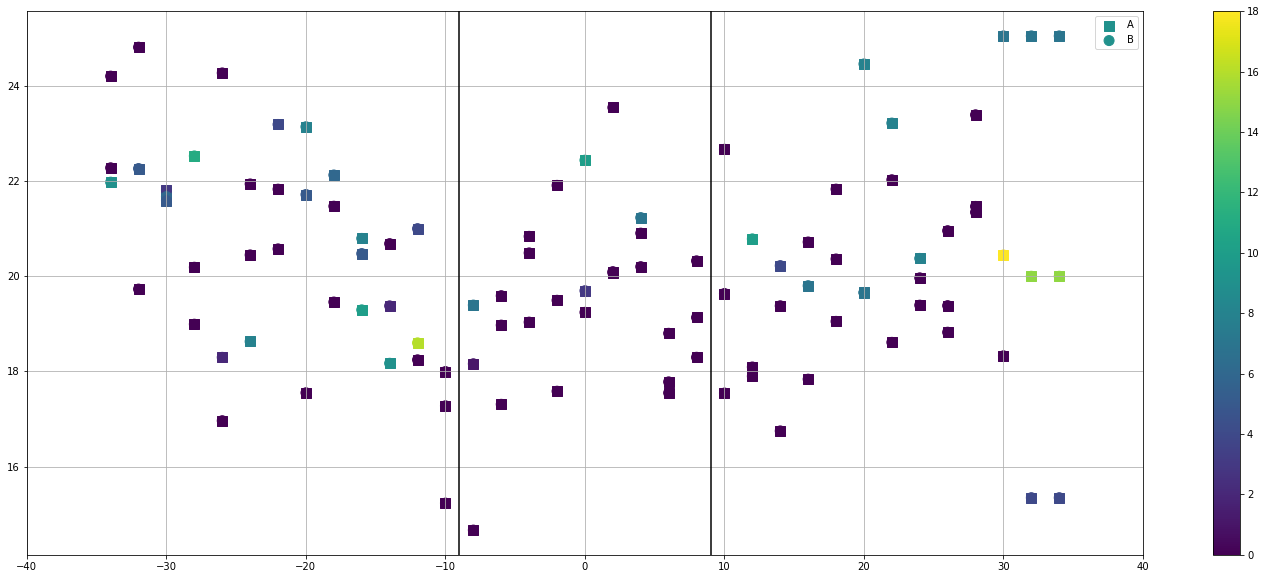

In [49]:
plot=postexplode.copy()
plot2=postexplode.copy()



plot=plot[plot['material']=='QL']
plot=plot[plot['plate_thickness']=='8']
plot=plot[plot['running_number'].isin (['v','iv','vi'])]
plot=plot[plot['testspeed']=='y']
plot=plot[plot['senergie/GW']!='GW']
plot=plot[plot['senergie/GW']=='A']
display('############')
display(plot[plot['senergie/GW']=='A'])
display('#######')
plot['Rp']=[float(x)/60000 for x in plot['Rp']]
#plot=plot[plot['Rp'].astype(float)>700]
#plot=plot[plot['Rp'].astype(float)<1500]
#plot.dropna(axis=0,inplace=True)

plot2=plot2[plot2['material']=='QL']
plot2=plot2[plot2['plate_thickness']=='8']
plot2=plot2[plot2['running_number'].isin (['v','iv','vi'])]
plot2=plot2[plot2['testspeed']=='y']
plot2=plot2[plot2['senergie/GW']!='GW']
plot2=plot2[plot2['senergie/GW']=='A']
plot2['Rp']=[float(x)/60000 for x in plot2['Rp']]
#plot2=plot2[plot2['Rp'].astype(float)>700]
#plot2=plot2[plot2['Rp'].astype(float)<1500]
#plot2.dropna(axis=0,inplace=True)



display(plot['level_0'].unique())
display(plot2['level_0'].unique())
##scatterplot
fig,ax=plt.subplots(figsize=(25,10))
a=ax.scatter(plot.post.astype(float),plot.Rp.astype(float),marker='s',c=plot['step_rp02'].astype(int),s=100,label='A')
b=ax.scatter(plot2.post.astype(float),plot2.Rp.astype(float),marker='o',c=plot2['step_rp02'].astype(int),s=100,label='B')
ax.set_xlim(-40,40)
ax.axvline(-9,color='k')
ax.axvline(9,color='k')
plt.colorbar(a)
plt.grid()
plt.legend()
plt.show()
fig.savefig('MC_mm.png',dpi=500)

In [ ]:
###parallel coordinatesplot
all=pd.DataFrame()
all['y1']=  plot.plate_thickness.astype(int)
all['y2']=  plot.post.astype(float)
all['y3']=  plot['senergie/GW'].map({'A':0.45,'B':0.3})
all['y4']=  plot.Rp.astype(float)
all['y5']=  plot['testspeed'].map({'x':10,'y':5})

y1= all['y1']
y3= all['y2']
y2= all['y3']
y4= all['y4']
y5= all['y5']

import plotly.express as px
df = px.data.iris()
fig = px.parallel_coordinates(all,
                              color="y4",
                              labels={"y1": "_plate_thickness",
                                      "y2": "position",
                                      "y3": "senergie",
                                      "y4": "Rp",
                                      'y5':'testspeed'},
                              color_continuous_scale=px.colors.sequential.Plasma,
                             )
fig.show()

In [337]:
"""for i in tests_df.index:
    plt.plot(posts,tests_df.loc[i,'Rp'])"""

"for i in tests_df.index:\n    plt.plot(posts,tests_df.loc[i,'Rp'])"

In [338]:
#display(list(tests_df.testspeed))

In [339]:
"""import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
import numpy as np

fig, host = plt.subplots()

# create some dummy data
ynames = ['thickness', 'testspeed', 'pos', 'Rp']
N1, N2, N3 = 10, 5, 8
N = N1 + N2 + N3
category = np.concatenate([np.full(N1, 1), np.full(N2, 2), np.full(N3, 3)])
y1 = plot.plate_thickness.astype(int)

y2 = plot.post.astype(float)
y3=plot.testspeed.map({'x':10,'y':5})
y4 = plot.Rp.astype(float)
#y5 = np.random.uniform(0, 800, N)

all=pd.DataFrame({
    'y1':y1,
    'y2':y2,
    'y3':y3,
    'y4':y4


})
display(all)
all.dropna(axis=0,inplace=True)
all=all[all['y4']>0]
all=all[all['y4']<1500]
display(all)

y1=all['y1']
y2=all['y2']
y3=all['y3']
y4=all['y4']

# organize the data
ys = np.dstack([y1, y2, y3, y4])[0]
ymins = ys.min(axis=0)
ymaxs = ys.max(axis=0)
dys = ymaxs - ymins
ymins -= dys * 0.05  # add 5% padding below and above
ymaxs += dys * 0.05
dys = ymaxs - ymins

# transform all data to be compatible with the main axis
zs = np.zeros_like(ys)
zs[:, 0] = ys[:, 0]
zs[:, 1:] = (ys[:, 1:] - ymins[1:]) / dys[1:] * dys[0] + ymins[0]


axes = [host] + [host.twinx() for i in range(ys.shape[1] - 1)]
for i, ax in enumerate(axes):
    ax.set_ylim(ymins[i], ymaxs[i])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    if ax != host:
        ax.spines['left'].set_visible(False)
        ax.yaxis.set_ticks_position('right')
        ax.spines["right"].set_position(("axes", i / (ys.shape[1] - 1)))

host.set_xlim(0, ys.shape[1] - 1)
host.set_xticks(range(ys.shape[1]))
host.set_xticklabels(ynames, fontsize=14)
host.tick_params(axis='x', which='major', pad=7)
host.spines['right'].set_visible(False)
host.xaxis.tick_top()
host.set_title('Parallel Coordinates Plot', fontsize=18)

colors = plt.cm.tab10.colors
for j in range(N):
    # to just draw straight lines between the axes:
    # host.plot(range(ys.shape[1]), zs[j,:], c=colors[(category[j] - 1) % len(colors) ])

    # create bezier curves
    # for each axis, there will a control vertex at the point itself, one at 1/3rd towards the previous and one
    #   at one third towards the next axis; the first and last axis have one less control vertex
    # x-coordinate of the control vertices: at each integer (for the axes) and two inbetween
    # y-coordinate: repeat every point three times, except the first and last only twice
    verts = list(zip([x for x in np.linspace(0, len(ys) - 1, len(ys) * 3 - 2, endpoint=True)],
                     np.repeat(zs[j, :], 3)[1:-1]))
    # for x,y in verts: host.plot(x, y, 'go') # to show the control points of the beziers
    codes = [Path.MOVETO] + [Path.CURVE4 for _ in range(len(verts) - 1)]
    path = Path(verts, codes)
    patch = patches.PathPatch(path, facecolor='none', lw=1, edgecolor=colors[category[j] - 1])
    host.add_patch(patch)
plt.tight_layout()
plt.show()"""

'import matplotlib.pyplot as plt\nfrom matplotlib.path import Path\nimport matplotlib.patches as patches\nimport numpy as np\n\nfig, host = plt.subplots()\n\n# create some dummy data\nynames = [\'thickness\', \'testspeed\', \'pos\', \'Rp\']\nN1, N2, N3 = 10, 5, 8\nN = N1 + N2 + N3\ncategory = np.concatenate([np.full(N1, 1), np.full(N2, 2), np.full(N3, 3)])\ny1 = plot.plate_thickness.astype(int)\n\ny2 = plot.post.astype(float)\ny3=plot.testspeed.map({\'x\':10,\'y\':5})\ny4 = plot.Rp.astype(float)\n#y5 = np.random.uniform(0, 800, N)\n\nall=pd.DataFrame({\n    \'y1\':y1,\n    \'y2\':y2,\n    \'y3\':y3,\n    \'y4\':y4\n\n\n})\ndisplay(all)\nall.dropna(axis=0,inplace=True)\nall=all[all[\'y4\']>0]\nall=all[all[\'y4\']<1500]\ndisplay(all)\n\ny1=all[\'y1\']\ny2=all[\'y2\']\ny3=all[\'y3\']\ny4=all[\'y4\']\n\n# organize the data\nys = np.dstack([y1, y2, y3, y4])[0]\nymins = ys.min(axis=0)\nymaxs = ys.max(axis=0)\ndys = ymaxs - ymins\nymins -= dys * 0.05  # add 5% padding below and above\nymaxs +

In [340]:
display(list(tests_df.columns))

['paths',
 'ok',
 'crack',
 'pos',
 'left_12-5',
 'step_start',
 'step_stop',
 'index',
 'material',
 'senergie/GW',
 'plate_thickness',
 'testspeed',
 'running_number',
 'data',
 '-35_-33_idxs',
 '-33_-31_idxs',
 '-31_-29_idxs',
 '-29_-27_idxs',
 '-27_-25_idxs',
 '-25_-23_idxs',
 '-23_-21_idxs',
 '-21_-19_idxs',
 '-19_-17_idxs',
 '-17_-15_idxs',
 '-15_-13_idxs',
 '-13_-11_idxs',
 '-11_-9 _idxs',
 '-9_-7  _idxs',
 '-7_-5  _idxs',
 '-5_-3  _idxs',
 '-3_-1  _idxs',
 '-1_1   _idxs',
 '1_3    _idxs',
 '3_5    _idxs',
 '5_7    _idxs',
 '7_9    _idxs',
 '9_11   _idxs',
 '11_13  _idxs',
 '13_15  _idxs',
 '15_17  _idxs',
 '17_19  _idxs',
 '19_21  _idxs',
 '21_23  _idxs',
 '23_25  _idxs',
 '25_27  _idxs',
 '27_29  _idxs',
 '29_31  _idxs',
 '31_33  _idxs',
 '33_35  _idxs',
 '-35_-33_strain_p1',
 '-33_-31_strain_p1',
 '-31_-29_strain_p1',
 '-29_-27_strain_p1',
 '-27_-25_strain_p1',
 '-25_-23_strain_p1',
 '-23_-21_strain_p1',
 '-21_-19_strain_p1',
 '-19_-17_strain_p1',
 '-17_-15_strain_p1',
 '-15_

In [341]:
"""i='QL_B_8xii_clipped_cut_lined'
fig,ax=plt.subplots(figsize=(15,10))
ax.plot(posts,tests_df.loc[i,'Rp'])"""

"i='QL_B_8xii_clipped_cut_lined'\nfig,ax=plt.subplots(figsize=(15,10))\nax.plot(posts,tests_df.loc[i,'Rp'])"

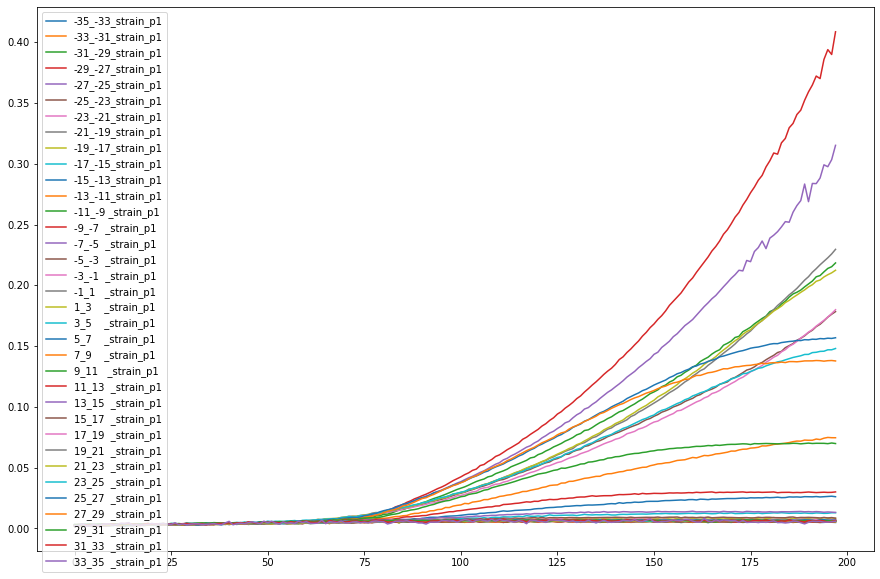

In [342]:
def contract():
    i='QL_B_8xii_clipped_cut_lined'
    fig,ax=plt.subplots(figsize=(15,10))
    ax.plot(tests_df.loc[i,'-35_-33_strain_p1'] ,label='-35_-33_strain_p1')
    ax.plot(tests_df.loc[i ,'-33_-31_strain_p1'],label='-33_-31_strain_p1')
    ax.plot(tests_df.loc[i ,'-31_-29_strain_p1'],label='-31_-29_strain_p1')
    ax.plot(tests_df.loc[i ,'-29_-27_strain_p1'],label='-29_-27_strain_p1')
    ax.plot(tests_df.loc[i ,'-27_-25_strain_p1'],label='-27_-25_strain_p1')
    ax.plot(tests_df.loc[i ,'-25_-23_strain_p1'],label='-25_-23_strain_p1')
    ax.plot(tests_df.loc[i ,'-23_-21_strain_p1'],label='-23_-21_strain_p1')
    ax.plot(tests_df.loc[i ,'-21_-19_strain_p1'],label='-21_-19_strain_p1')
    ax.plot(tests_df.loc[i ,'-19_-17_strain_p1'],label='-19_-17_strain_p1')
    ax.plot(tests_df.loc[i ,'-17_-15_strain_p1'],label='-17_-15_strain_p1')
    ax.plot(tests_df.loc[i ,'-15_-13_strain_p1'],label='-15_-13_strain_p1')
    ax.plot(tests_df.loc[i ,'-13_-11_strain_p1'],label='-13_-11_strain_p1')
    ax.plot(tests_df.loc[i ,'-11_-9 _strain_p1'],label='-11_-9 _strain_p1')
    ax.plot(tests_df.loc[i ,'-9_-7  _strain_p1'],label='-9_-7  _strain_p1')
    ax.plot(tests_df.loc[i ,'-7_-5  _strain_p1'],label='-7_-5  _strain_p1')
    ax.plot(tests_df.loc[i ,'-5_-3  _strain_p1'],label='-5_-3  _strain_p1')
    ax.plot(tests_df.loc[i ,'-3_-1  _strain_p1'],label='-3_-1  _strain_p1')
    ax.plot(tests_df.loc[i ,'-1_1   _strain_p1'],label='-1_1   _strain_p1')
    ax.plot(tests_df.loc[i ,'1_3    _strain_p1'],label='1_3    _strain_p1')
    ax.plot(tests_df.loc[i ,'3_5    _strain_p1'],label='3_5    _strain_p1')
    ax.plot(tests_df.loc[i ,'5_7    _strain_p1'],label='5_7    _strain_p1')
    ax.plot(tests_df.loc[i ,'7_9    _strain_p1'],label='7_9    _strain_p1')
    ax.plot(tests_df.loc[i ,'9_11   _strain_p1'],label='9_11   _strain_p1')
    ax.plot(tests_df.loc[i ,'11_13  _strain_p1'],label='11_13  _strain_p1')
    ax.plot(tests_df.loc[i ,'13_15  _strain_p1'],label='13_15  _strain_p1')
    ax.plot(tests_df.loc[i ,'15_17  _strain_p1'],label='15_17  _strain_p1')
    ax.plot(tests_df.loc[i ,'17_19  _strain_p1'],label='17_19  _strain_p1')
    ax.plot(tests_df.loc[i ,'19_21  _strain_p1'],label='19_21  _strain_p1')
    ax.plot(tests_df.loc[i ,'21_23  _strain_p1'],label='21_23  _strain_p1')
    ax.plot(tests_df.loc[i ,'23_25  _strain_p1'],label='23_25  _strain_p1')
    ax.plot(tests_df.loc[i ,'25_27  _strain_p1'],label='25_27  _strain_p1')
    ax.plot(tests_df.loc[i ,'27_29  _strain_p1'],label='27_29  _strain_p1')
    ax.plot(tests_df.loc[i ,'29_31  _strain_p1'],label='29_31  _strain_p1')
    ax.plot(tests_df.loc[i ,'31_33  _strain_p1'],label='31_33  _strain_p1')
    ax.plot(tests_df.loc[i ,'33_35  _strain_p1'],label='33_35  _strain_p1')
    ax.legend(loc='upper left')
    plt.show()
contract()

In [343]:
"""plot=plot[plot['material']=='MC']
plot=plot[plot['plate_thickness']=='6']
plot=plot[plot['senergie/GW']=='A']
y2 = plot.post.astype(float)
y3=plot.testspeed.map({'x':10,'y':5})
y4 = plot.Rp.astype(float)
#y5 = np.random.uniform(0, 800, N)

all=pd.DataFrame({
    'y1':y1,
    'y2':y2,
    'y3':y3,
    'y4':y4


})
import plotly.express as px
df = px.data.iris()
fig = px.parallel_coordinates(all, color="y4", labels={"y1": "plate_thickness",
                "y2": "position", "y3": "test_speed",
                "y4": "Rp" },
                             color_continuous_scale='viridis',#px.colors.qualitative.Dark24,
                             color_continuous_midpoint=2)
fig.show()"""

'plot=plot[plot[\'material\']==\'MC\']\nplot=plot[plot[\'plate_thickness\']==\'6\']\nplot=plot[plot[\'senergie/GW\']==\'A\']\ny2 = plot.post.astype(float)\ny3=plot.testspeed.map({\'x\':10,\'y\':5})\ny4 = plot.Rp.astype(float)\n#y5 = np.random.uniform(0, 800, N)\n\nall=pd.DataFrame({\n    \'y1\':y1,\n    \'y2\':y2,\n    \'y3\':y3,\n    \'y4\':y4\n\n\n})\nimport plotly.express as px\ndf = px.data.iris()\nfig = px.parallel_coordinates(all, color="y4", labels={"y1": "plate_thickness",\n                "y2": "position", "y3": "test_speed",\n                "y4": "Rp" },\n                             color_continuous_scale=\'viridis\',#px.colors.qualitative.Dark24,\n                             color_continuous_midpoint=2)\nfig.show()'

In [344]:
i='QL_B_8xii_clipped_cut_lined'
display(tests_df.loc[i,'-15_-13_rp02'])

1096.754372965333